In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch

from dyck_k_generator import constants

In [3]:
device = (
    "cuda:0"
    if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available() else "cpu"
)
device

'cuda:0'

In [4]:
if device == "mps":
    torch.mps.empty_cache()
elif device == "cuda:0":
    torch.cuda.empty_cache()

In [5]:
torch.manual_seed(42)

In [6]:
k = 1

In [7]:
from dyck_k_generator.generator import generate_dataset

path = generate_dataset(
    n=10_000,
    k=k,
    min_length=0,
    max_length=16,
    balanced=0.5,
)

File data/dyck-1_10000-samples_16-len_p05.jsonl already exists.


In [8]:
VOCAB = "".join(
    ["".join((key, value)) for key, value in list(constants.BRACKETS.items())[:k]]
)
VOCAB

'()'

In [9]:
from dataset.dataset import DyckLanguageDataset

In [10]:
dataset = DyckLanguageDataset(path, VOCAB).to(device)

Loaded 10000 samples from data/dyck-1_10000-samples_16-len_p05.jsonl


Padding strings: 100%|██████████| 10000/10000 [00:00<00:00, 6463713.98it/s]


In [11]:
from torch.utils.data import random_split

train_size = int(0.8 * len(dataset))
val_size = int(0.15 * train_size)
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(
    dataset, [train_size, val_size, test_size]
)

In [12]:
from torch.utils.data import DataLoader

In [13]:
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=4, shuffle=True)

# Hooked Transformer (Bidirectional mask) - Dyck-1 dataset


In [14]:
from transformer.hooked_transformer import (
    TransformerClassifier,
    TransformerClassifierConfig,
    causal_mask,
    pad_token_mask,
)

In [15]:
model_config = TransformerClassifierConfig(
    vocab_size=len(VOCAB),
    d_model=256,
    n_heads=1,
    dim_ff=512,
    n_layers=2,
    n_classes=2,
    max_seq_len=16,
)

In [16]:
model_bidirectional = TransformerClassifier(model_config)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: matiasmolinolo. Use `wandb login --relogin` to force relogin


In [17]:
model_bidirectional.to(device)

TransformerClassifier(
  (embedding): Embedding(5, 256)
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x EncoderBlock(
        (attn): MultiHeadAttention(
          (q_linear): Linear(in_features=256, out_features=256, bias=True)
          (k_linear): Linear(in_features=256, out_features=256, bias=True)
          (v_linear): Linear(in_features=256, out_features=256, bias=True)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (residual_dropout): Dropout(p=0.1, inplace=False)
          (attn): ScaledDotProductAttention()
          (out): Linear(in_features=256, out_features=256, bias=True)
        )
        (ff): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): Dropout(p=0.1, inplace=False)
          (2): ReLU(inplace=True)
          (3): Linear(in_features=512, out_features=256, bias=True)
        )
        (ln1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (ln2): LayerNorm((2

In [18]:
import torch.optim as optim

crit = torch.nn.CrossEntropyLoss()

optimizer = optim.Adam(model_bidirectional.parameters(), lr=1e-5)

In [19]:
train_loss, train_acc, val_loss, val_acc = model_bidirectional.train_model(
    device=device,
    epochs=20,
    optimizer=optimizer,
    criterion=crit,
    train_dataloader=train_dataloader,
    eval_dataloader=val_dataloader,
    use_mask="bidirectional",
)

Epoch 1/20


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.5298 | Train Accuracy: 63.47%
Train Loss: 0.3620 | Train Accuracy: 69.70%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 26.1786 | Validation Accuracy: 91.88%
Train Loss: 131.2966 | Train Acc: 71.76%
Val Loss: 37.5243 | Val Acc: 92.25%
Epoch 2/20


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.2543 | Train Accuracy: 84.94%
Train Loss: 0.1397 | Train Accuracy: 86.72%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 18.1445 | Validation Accuracy: 91.88%
Train Loss: 62.8923 | Train Acc: 87.40%
Val Loss: 26.9066 | Val Acc: 92.25%
Epoch 3/20


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.2268 | Train Accuracy: 88.12%
Train Loss: 0.1521 | Train Accuracy: 89.20%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 16.1222 | Validation Accuracy: 92.38%
Train Loss: 49.3822 | Train Acc: 89.75%
Val Loss: 24.5168 | Val Acc: 92.25%
Epoch 4/20


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.1187 | Train Accuracy: 89.53%
Train Loss: 0.1163 | Train Accuracy: 90.38%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 16.6100 | Validation Accuracy: 92.25%
Train Loss: 45.7776 | Train Acc: 90.56%
Val Loss: 23.8389 | Val Acc: 92.25%
Epoch 5/20


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.1943 | Train Accuracy: 91.62%
Train Loss: 0.1625 | Train Accuracy: 90.48%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 14.7167 | Validation Accuracy: 92.75%
Train Loss: 46.0165 | Train Acc: 90.48%
Val Loss: 23.3762 | Val Acc: 92.25%
Epoch 6/20


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.0678 | Train Accuracy: 90.78%
Train Loss: 0.2395 | Train Accuracy: 90.94%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 14.7120 | Validation Accuracy: 92.62%
Train Loss: 44.1995 | Train Acc: 90.89%
Val Loss: 23.2365 | Val Acc: 92.25%
Epoch 7/20


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.0808 | Train Accuracy: 92.22%
Train Loss: 0.0154 | Train Accuracy: 93.73%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 10.5150 | Validation Accuracy: 96.62%
Train Loss: 35.9350 | Train Acc: 94.34%
Val Loss: 14.3425 | Val Acc: 97.00%
Epoch 8/20


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.1051 | Train Accuracy: 96.72%
Train Loss: 0.1871 | Train Accuracy: 96.92%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 8.8005 | Validation Accuracy: 96.88%
Train Loss: 24.5676 | Train Acc: 96.94%
Val Loss: 13.0611 | Val Acc: 97.00%
Epoch 9/20


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.0210 | Train Accuracy: 97.59%
Train Loss: 0.0889 | Train Accuracy: 97.22%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 6.5307 | Validation Accuracy: 97.50%
Train Loss: 20.8207 | Train Acc: 97.17%
Val Loss: 11.1417 | Val Acc: 97.00%
Epoch 10/20


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.0301 | Train Accuracy: 97.19%
Train Loss: 0.0566 | Train Accuracy: 97.12%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 3.5677 | Validation Accuracy: 96.88%
Train Loss: 17.3537 | Train Acc: 97.12%
Val Loss: 5.2056 | Val Acc: 97.00%
Epoch 11/20


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.0098 | Train Accuracy: 98.97%
Train Loss: 0.0187 | Train Accuracy: 99.41%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 0.2596 | Validation Accuracy: 100.00%
Train Loss: 5.3377 | Train Acc: 99.50%
Val Loss: 0.3813 | Val Acc: 100.00%
Epoch 12/20


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.0040 | Train Accuracy: 100.00%
Train Loss: 0.0026 | Train Accuracy: 99.97%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 0.0726 | Validation Accuracy: 100.00%
Train Loss: 1.3570 | Train Acc: 99.94%
Val Loss: 0.1067 | Val Acc: 100.00%
Epoch 13/20


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.0009 | Train Accuracy: 100.00%
Train Loss: 0.0025 | Train Accuracy: 100.00%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 0.0256 | Validation Accuracy: 100.00%
Train Loss: 0.5250 | Train Acc: 100.00%
Val Loss: 0.0411 | Val Acc: 100.00%
Epoch 14/20


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.0013 | Train Accuracy: 99.94%
Train Loss: 0.0017 | Train Accuracy: 99.84%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 0.0346 | Validation Accuracy: 100.00%
Train Loss: 2.5012 | Train Acc: 99.69%
Val Loss: 0.0509 | Val Acc: 100.00%
Epoch 15/20


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.0008 | Train Accuracy: 100.00%
Train Loss: 0.0006 | Train Accuracy: 100.00%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 0.0135 | Validation Accuracy: 100.00%
Train Loss: 0.3132 | Train Acc: 100.00%
Val Loss: 0.0209 | Val Acc: 100.00%
Epoch 16/20


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.0004 | Train Accuracy: 100.00%
Train Loss: 0.0009 | Train Accuracy: 100.00%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 0.0095 | Validation Accuracy: 100.00%
Train Loss: 0.1997 | Train Acc: 100.00%
Val Loss: 0.0152 | Val Acc: 100.00%
Epoch 17/20


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.0005 | Train Accuracy: 100.00%
Train Loss: 0.0005 | Train Accuracy: 99.97%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 0.0089 | Validation Accuracy: 100.00%
Train Loss: 0.2853 | Train Acc: 99.98%
Val Loss: 0.0132 | Val Acc: 100.00%
Epoch 18/20


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.0002 | Train Accuracy: 100.00%
Train Loss: 0.0007 | Train Accuracy: 99.97%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 0.0076 | Validation Accuracy: 100.00%
Train Loss: 0.2802 | Train Acc: 99.98%
Val Loss: 0.0111 | Val Acc: 100.00%
Epoch 19/20


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.0004 | Train Accuracy: 99.97%
Train Loss: 0.0004 | Train Accuracy: 99.98%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 0.0056 | Validation Accuracy: 100.00%
Train Loss: 0.1643 | Train Acc: 99.99%
Val Loss: 0.0086 | Val Acc: 100.00%
Epoch 20/20


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.0002 | Train Accuracy: 100.00%
Train Loss: 0.0002 | Train Accuracy: 100.00%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 0.0045 | Validation Accuracy: 100.00%
Train Loss: 0.0750 | Train Acc: 100.00%
Val Loss: 0.0065 | Val Acc: 100.00%


In [20]:
test_loss, test_acc = model_bidirectional.eval_model(
    device=device,
    test_dataloader=test_dataloader,
    criterion=crit,
    use_mask="bidirectional",
)

  0%|          | 0/200 [00:00<?, ?it/s]

Test Loss: 0.0046 | Test Accuracy: 100.00%
Test Loss: 0.0096 | Test Accuracy: 100.00%
Test Loss: 0.0096 | Test Acc: 100.00%


test/acc,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test/loss,▃▁▃▆▁█▁█▁▇▁▁▂▁▃▂▁▂▂▂▂▇▂▆▂▂▂▁▁▃▂▁▆▁▁▁▁▇▆▄
test_acc,▁
test_loss,▁
train/acc,▁▂▄▆▆▆▇▆▇▆▆▆▇▇▇▇████████████████████████
train/loss,▇█▄▄▂▂▂▂▃▂▂▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val/acc,▁▁▄▁▂▁▂▂▅▂▅▂▇▅▆▅▅▆▇▅████████████████████
val/loss,▅██▁▇▃▄▁▂▇▂▄▂▂▇▁▆▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test/acc,100.0
test/loss,7e-05
test_acc,100.0


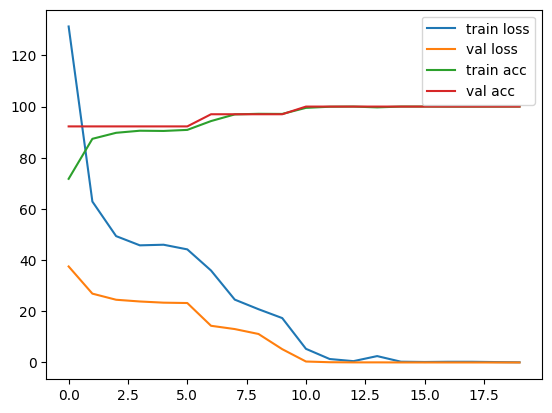

In [21]:
import matplotlib.pyplot as plt

plt.plot(train_loss, label="train loss")
plt.plot(val_loss, label="val loss")
plt.plot(train_acc, label="train acc")
plt.plot(val_acc, label="val acc")
plt.legend()
plt.show()

# Hooked Transformer (causal mask) - Dyck-1 dataset

In [22]:
model_causal = TransformerClassifier(model_config).to(device)

In [23]:
crit = torch.nn.CrossEntropyLoss()

optimizer = optim.Adam(model_causal.parameters(), lr=1e-4)

In [24]:
train_loss, train_acc, val_loss, val_acc = model_causal.train_model(
    device=device,
    epochs=10,
    optimizer=optimizer,
    criterion=crit,
    train_dataloader=train_dataloader,
    eval_dataloader=val_dataloader,
    use_mask="causal",
)

Epoch 1/10


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.7217 | Train Accuracy: 50.53%
Train Loss: 0.7082 | Train Accuracy: 50.84%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 73.0823 | Validation Accuracy: 48.88%
Train Loss: 177.9722 | Train Acc: 50.32%
Val Loss: 109.2104 | Val Acc: 49.42%
Epoch 2/10


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.6764 | Train Accuracy: 52.00%
Train Loss: 0.7179 | Train Accuracy: 50.50%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 69.3242 | Validation Accuracy: 50.38%
Train Loss: 174.6800 | Train Acc: 50.76%
Val Loss: 104.0528 | Val Acc: 49.42%
Epoch 3/10


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.6974 | Train Accuracy: 50.47%
Train Loss: 0.6973 | Train Accuracy: 50.28%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 69.8740 | Validation Accuracy: 50.50%
Train Loss: 174.7599 | Train Acc: 50.22%
Val Loss: 104.7818 | Val Acc: 50.58%
Epoch 4/10


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.7327 | Train Accuracy: 50.03%
Train Loss: 0.7131 | Train Accuracy: 50.62%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 69.3372 | Validation Accuracy: 49.25%
Train Loss: 174.4273 | Train Acc: 50.29%
Val Loss: 104.0003 | Val Acc: 49.42%
Epoch 5/10


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.6981 | Train Accuracy: 50.22%
Train Loss: 0.7196 | Train Accuracy: 50.02%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 69.4339 | Validation Accuracy: 50.25%
Train Loss: 174.5978 | Train Acc: 50.52%
Val Loss: 104.0967 | Val Acc: 50.58%
Epoch 6/10


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.6991 | Train Accuracy: 50.00%
Train Loss: 0.6872 | Train Accuracy: 49.86%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 69.2483 | Validation Accuracy: 52.38%
Train Loss: 174.1223 | Train Acc: 49.74%
Val Loss: 103.9640 | Val Acc: 50.58%
Epoch 7/10


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.6965 | Train Accuracy: 49.91%
Train Loss: 0.7063 | Train Accuracy: 50.02%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 69.3557 | Validation Accuracy: 48.25%
Train Loss: 173.7802 | Train Acc: 50.04%
Val Loss: 103.9620 | Val Acc: 50.58%
Epoch 8/10


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.6981 | Train Accuracy: 49.50%
Train Loss: 0.7036 | Train Accuracy: 50.33%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 69.4093 | Validation Accuracy: 51.62%
Train Loss: 173.7137 | Train Acc: 50.11%
Val Loss: 104.3855 | Val Acc: 50.58%
Epoch 9/10


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.7047 | Train Accuracy: 49.62%
Train Loss: 0.7076 | Train Accuracy: 49.50%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 69.3293 | Validation Accuracy: 50.62%
Train Loss: 174.2303 | Train Acc: 49.12%
Val Loss: 103.9982 | Val Acc: 50.58%
Epoch 10/10


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.7008 | Train Accuracy: 51.56%
Train Loss: 0.6984 | Train Accuracy: 50.89%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 69.3360 | Validation Accuracy: 49.62%
Train Loss: 173.8594 | Train Acc: 50.42%
Val Loss: 104.0131 | Val Acc: 49.42%


In [25]:
test_loss, test_acc = model_causal.eval_model(
    device=device,
    test_dataloader=test_dataloader,
    criterion=crit,
    use_mask="causal",
)

  0%|          | 0/200 [00:00<?, ?it/s]

Test Loss: 69.2384 | Test Accuracy: 53.00%
Test Loss: 138.5202 | Test Accuracy: 52.25%
Test Loss: 138.5202 | Test Acc: 52.25%


test/acc,▁█▅▅▆▆▆▆▆▆▇▇▆▆▆▆▆▆▇▆▆▇▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆
test/loss,▆▆▆▆▆▁▆▃▁▃▃▆█▆█▆▃▃▆▆▆▆█▁▆▆▆▆█▆▃▃▆▃▆█▁▁▆█
test_acc,▁
test_loss,▁
train/acc,▄▄▄▄▃▇▄▄▂▃▃▃▂▂▄▄█▃▂▃▆▃▂▂▃▂▃▃▁▂▃▃▁▂▂▁▂▅▅▃
train/loss,▅▁▆█▂▆▄▄▅▄▄▃▃▃▃▃▃▃▄▃▄▃▄▃▃▃▃▃▃▄▃▃▅▃▃▃▄▃▃▃
val/acc,▅▅▅▄▄▄▅▄█▅▅▄▃▃▄▄▆▃▅▅▅▆▆▅▁▄▃▄▇▄▆▄▂▄▄▅▃▄▄▃
val/loss,▅▅██▃▄▃▃▂▄▁▂▄▄▃▃▄▅▅▂▄▃▄▃▃▃▃▃▃▃▂▃▃▃▄▃▃▄▄▄
test/acc,52.25
test/loss,0.70048
test_acc,52.25


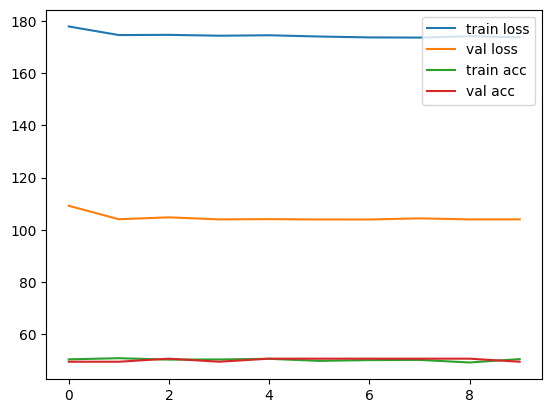

In [26]:
import matplotlib.pyplot as plt

plt.plot(train_loss, label="train loss")
plt.plot(val_loss, label="val loss")
plt.plot(train_acc, label="train acc")
plt.plot(val_acc, label="val acc")
plt.legend()
plt.show()

# Attention plots:


In [27]:
from transformer_viz.visualizer import min_max_normalize, plot_attn_matrices

In [28]:
from dataset.dataset import DyckLanguageTokenizer
from dyck_k_generator.checker import is_dyck_word

In [29]:
batch = (
    ")))))))(((((((",
    is_dyck_word(")))))))(((((((", k=1),
    DyckLanguageTokenizer(VOCAB).tokenize(")))))))(((((((").to(device),
)
batch

Padding strings: 100%|██████████| 1/1 [00:00<00:00, 52428.80it/s]


(')))))))(((((((',
 False,
 tensor([[0., 4., 4., 4., 4., 4., 4., 4., 3., 3., 3., 3., 3., 3., 3., 2.]],
        device='cuda:0'))

In [30]:
batch = next(iter(test_dataloader))

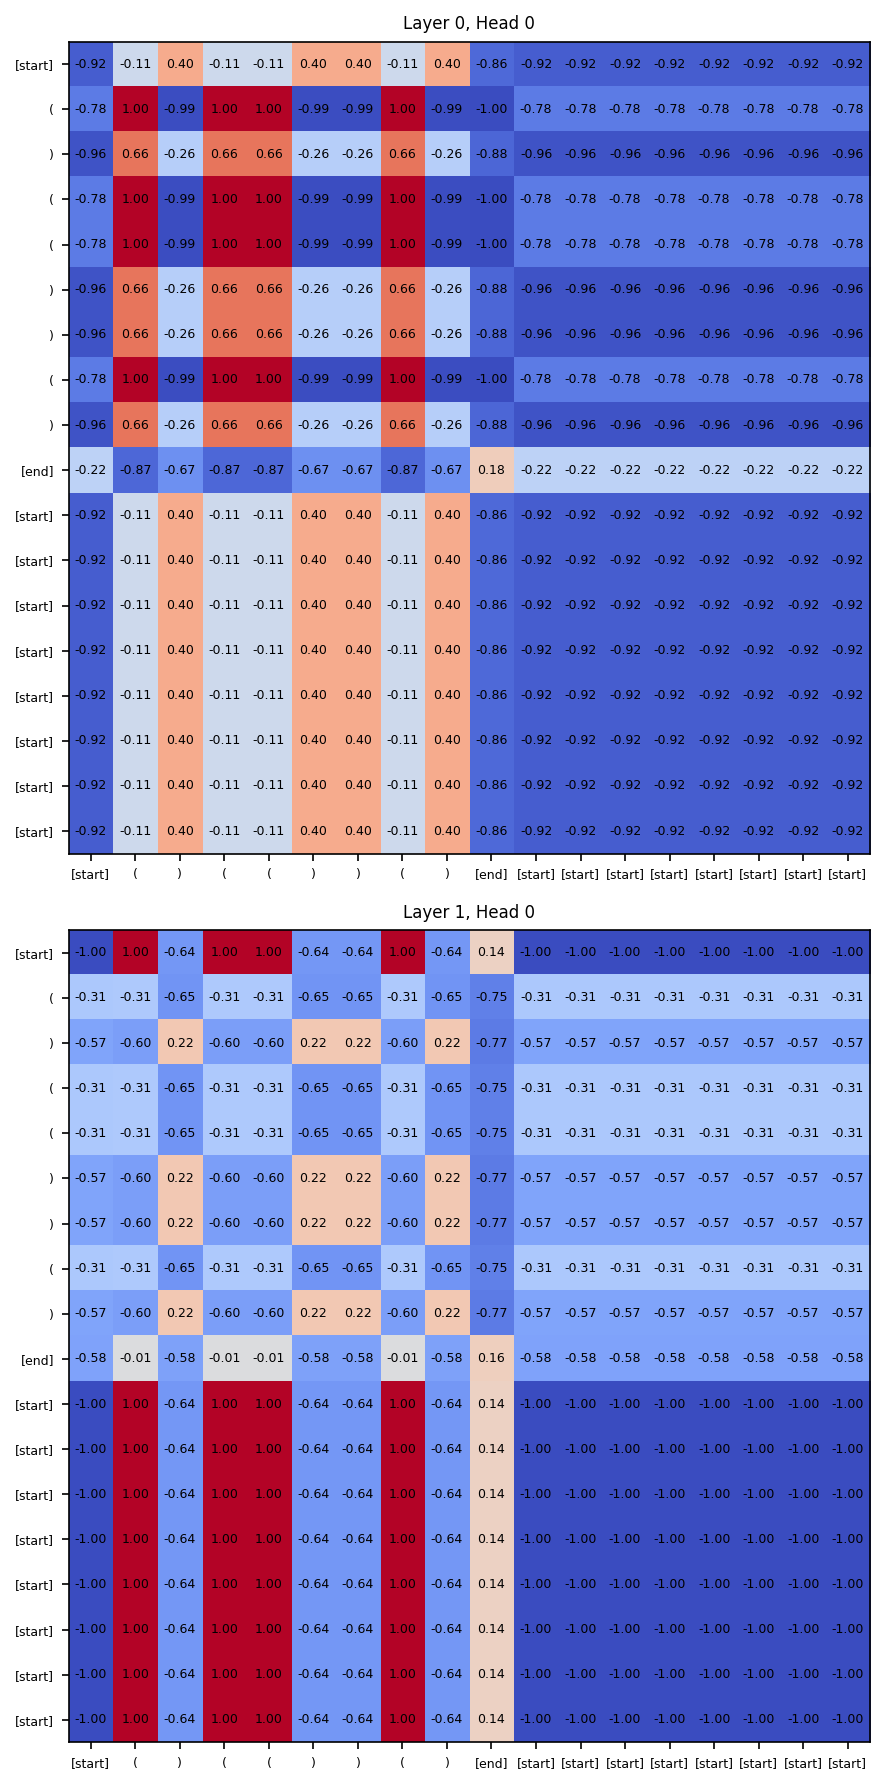

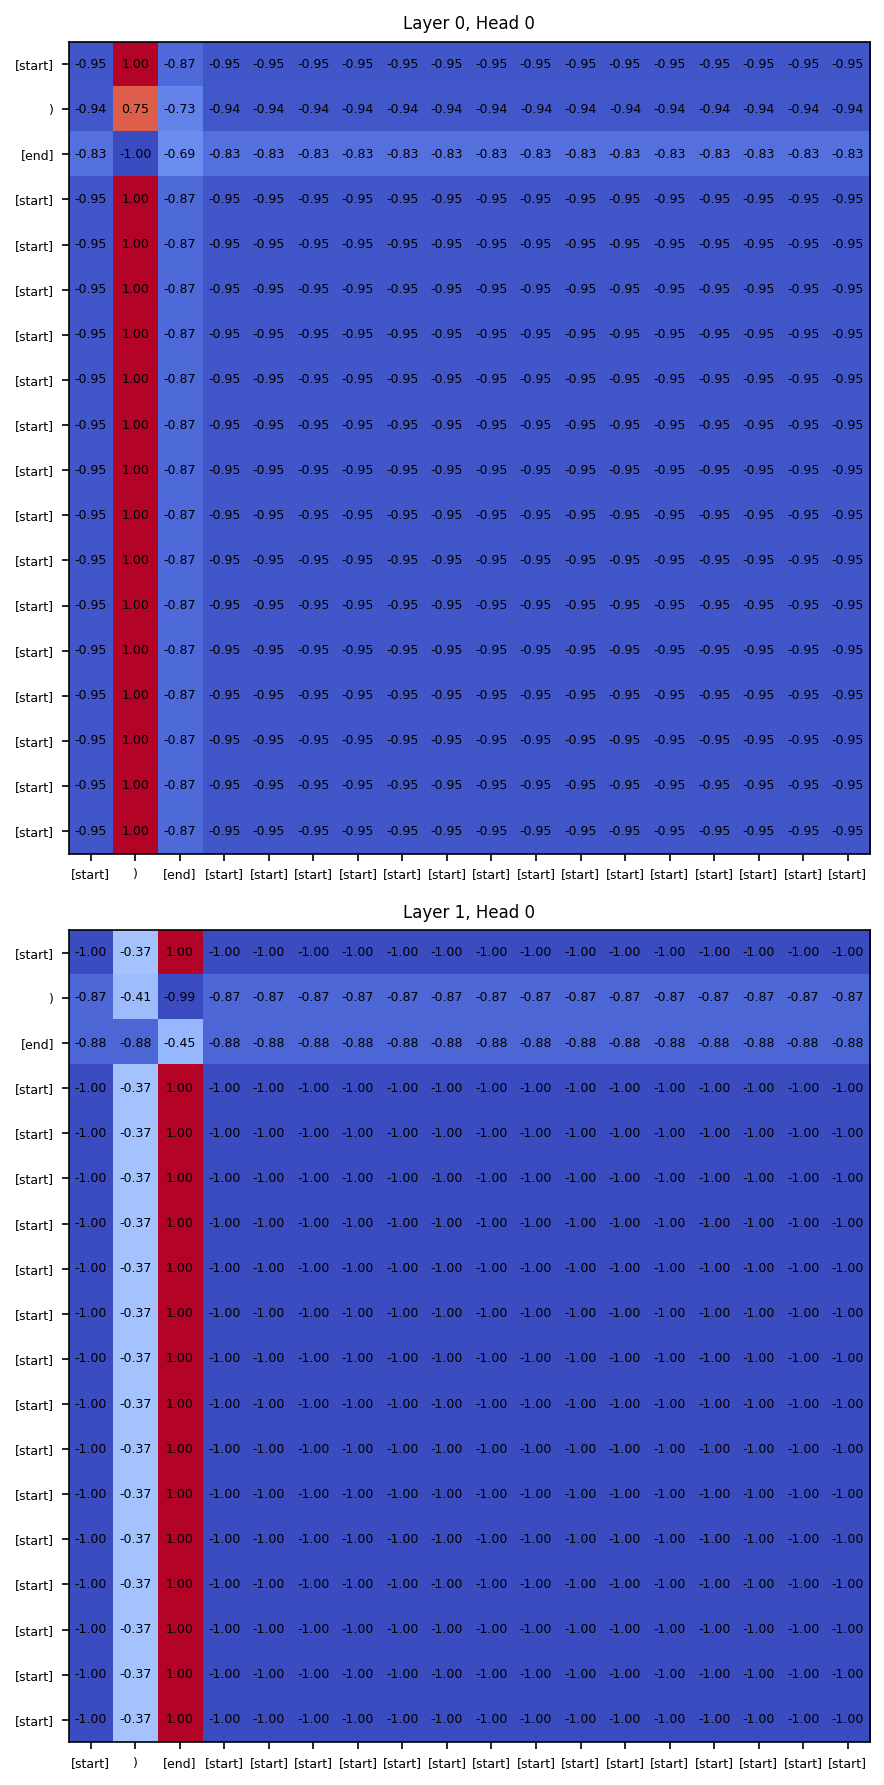

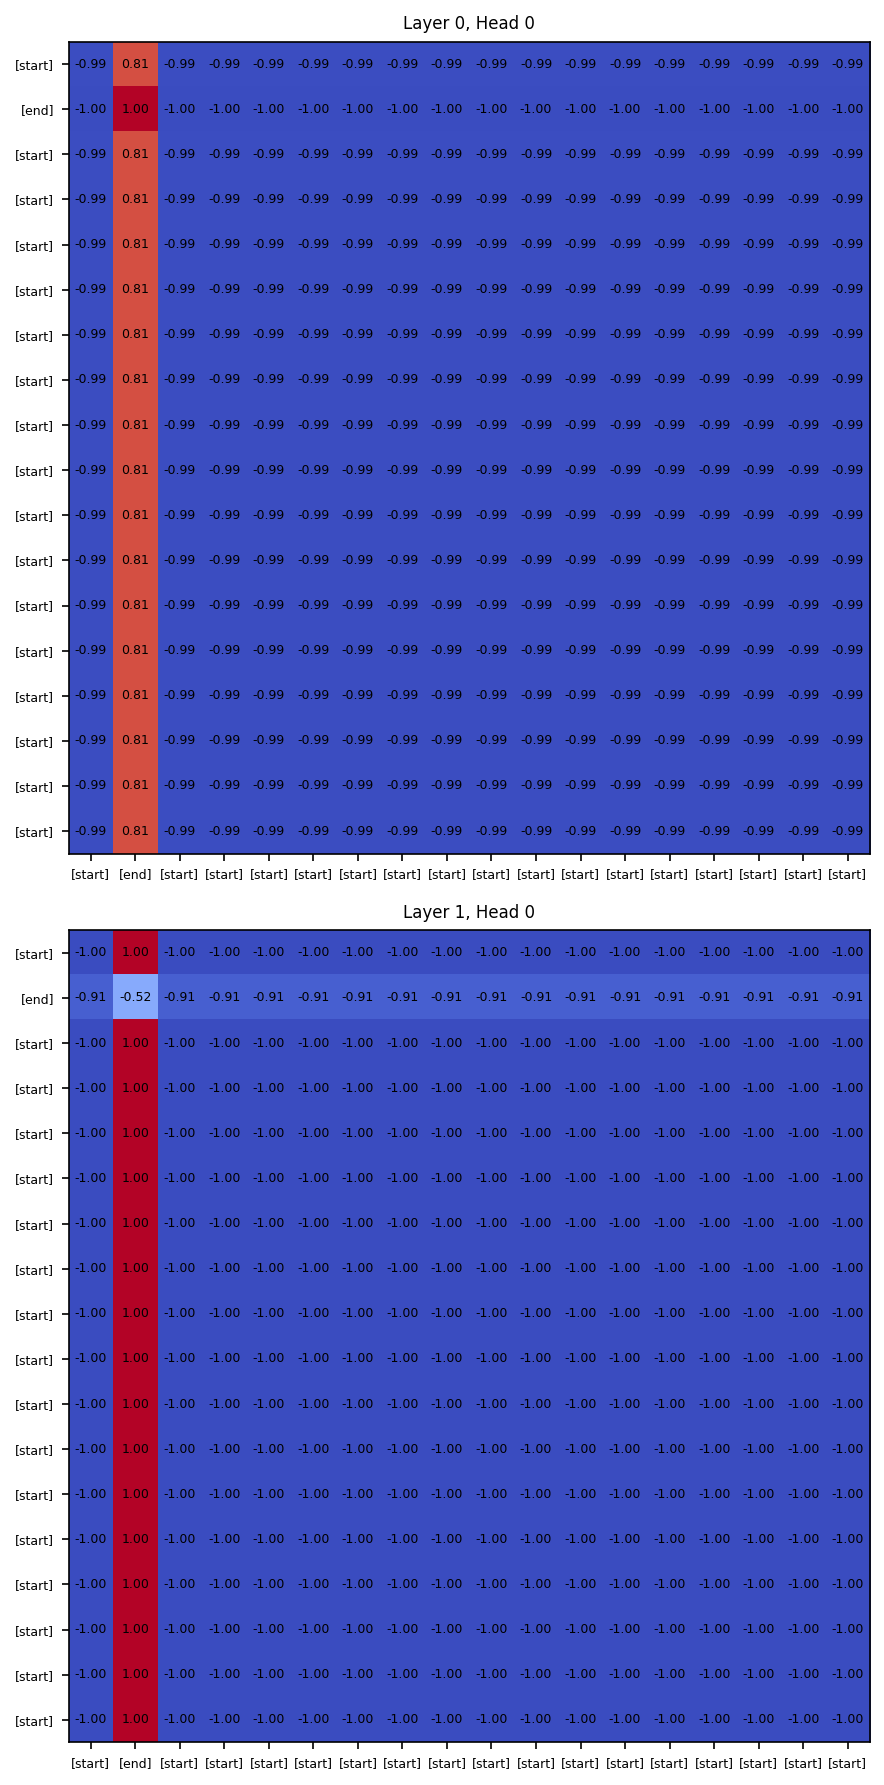

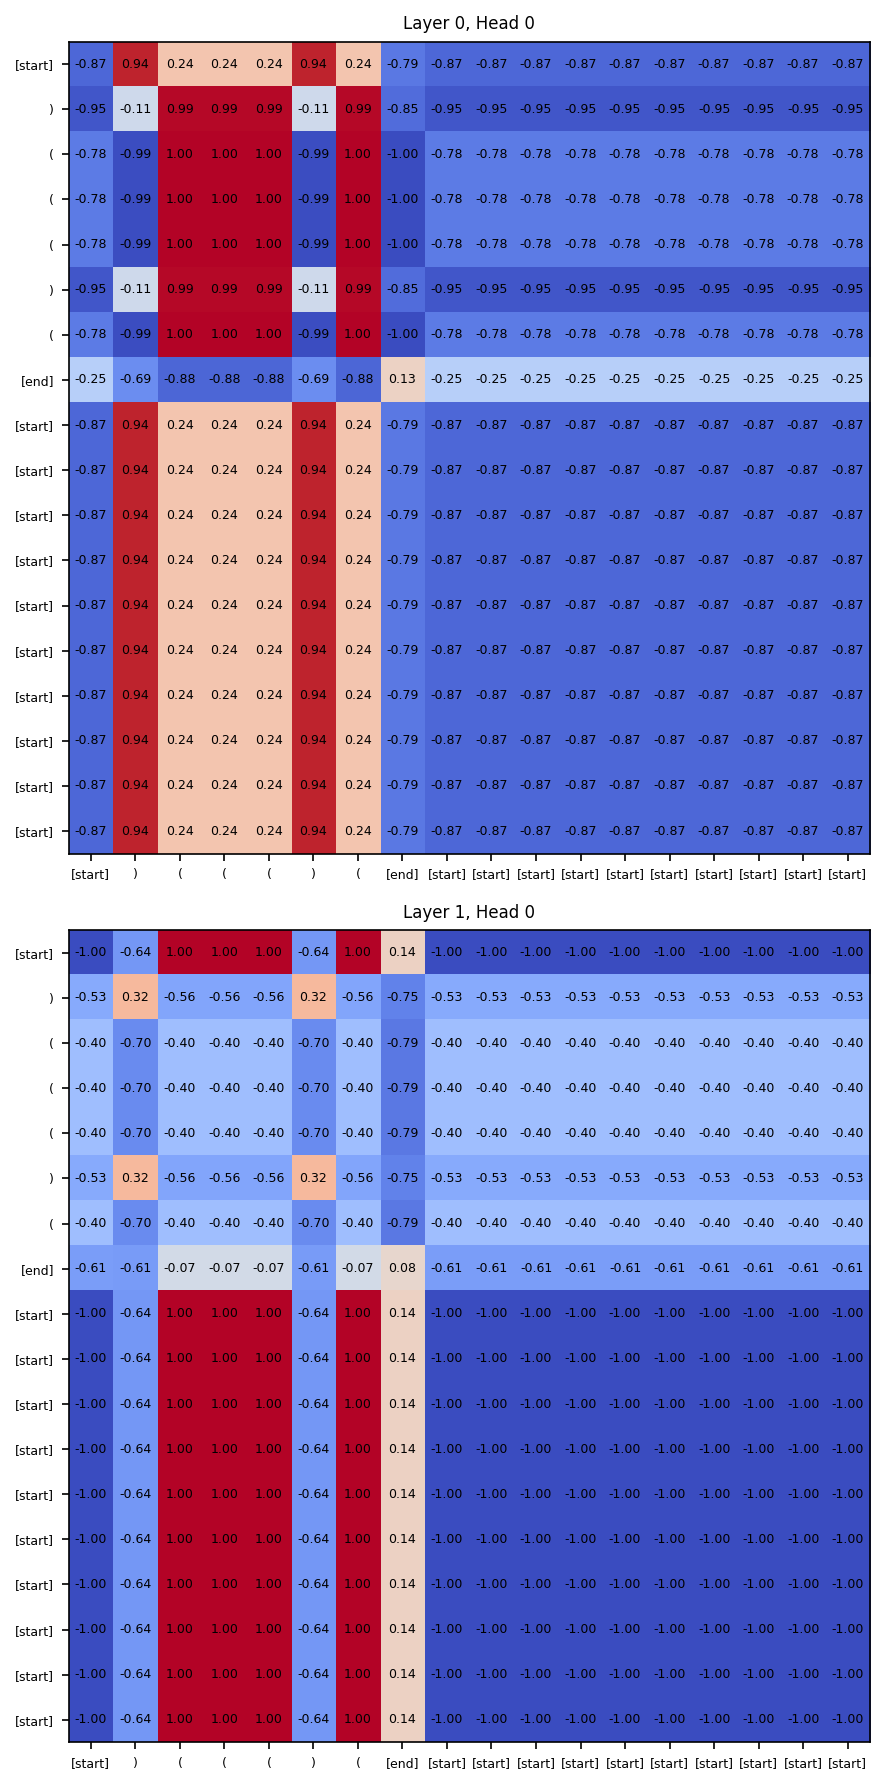

In [31]:
plot_attn_matrices(VOCAB, batch, model_bidirectional, min_max_normalize, pad_token_mask)

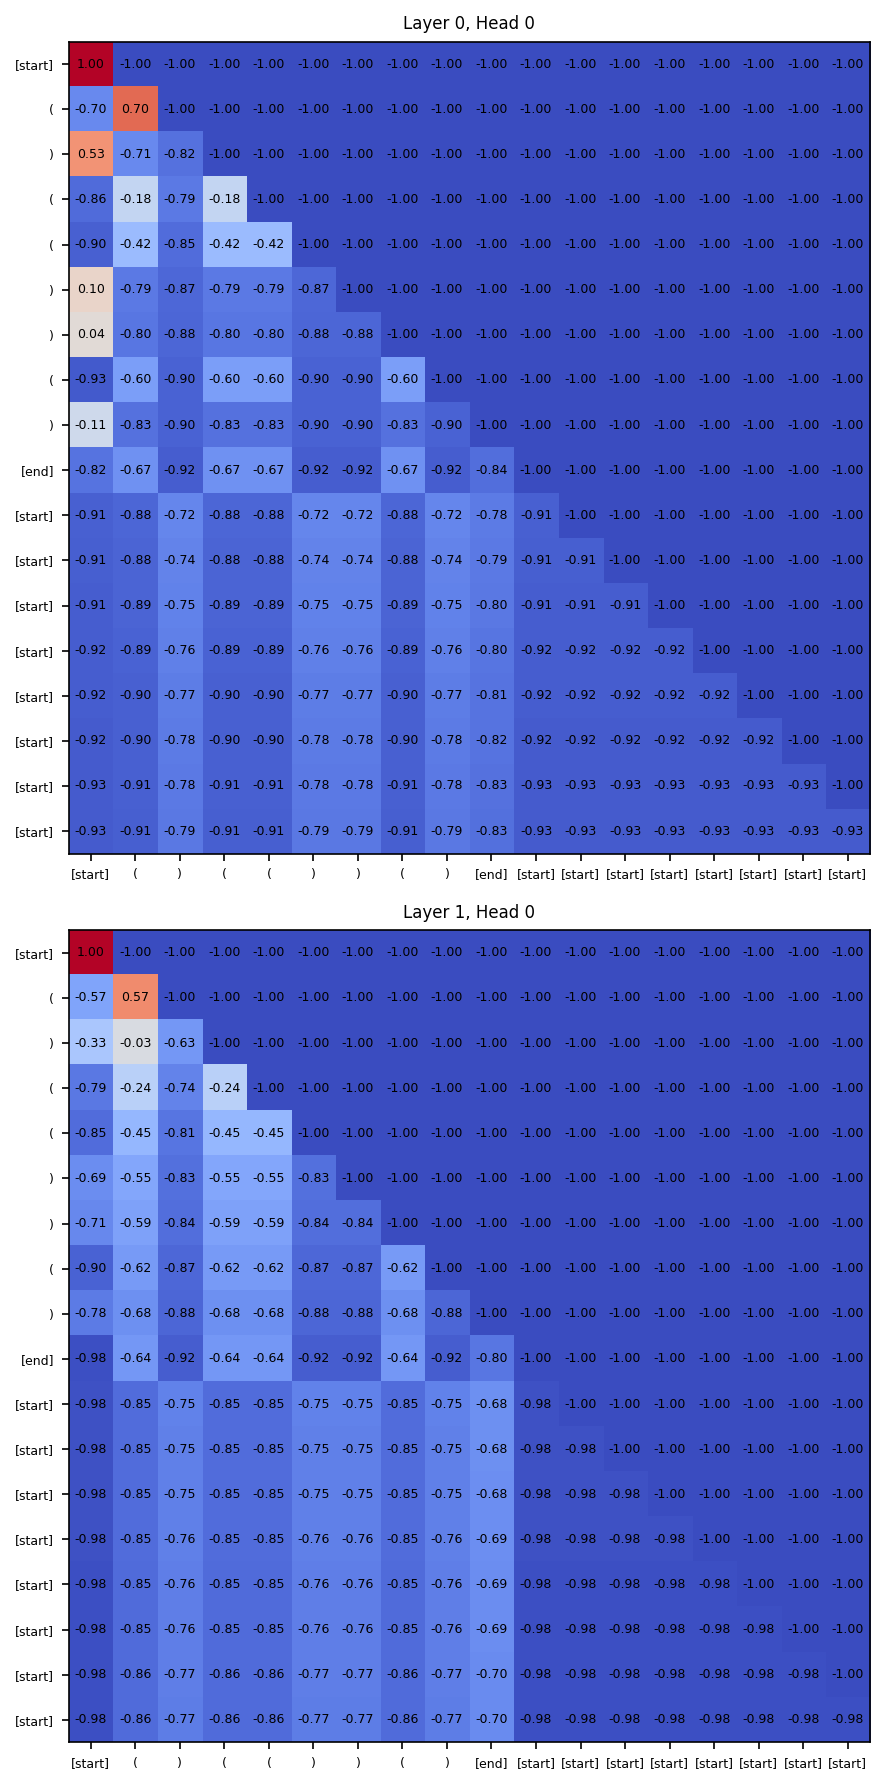

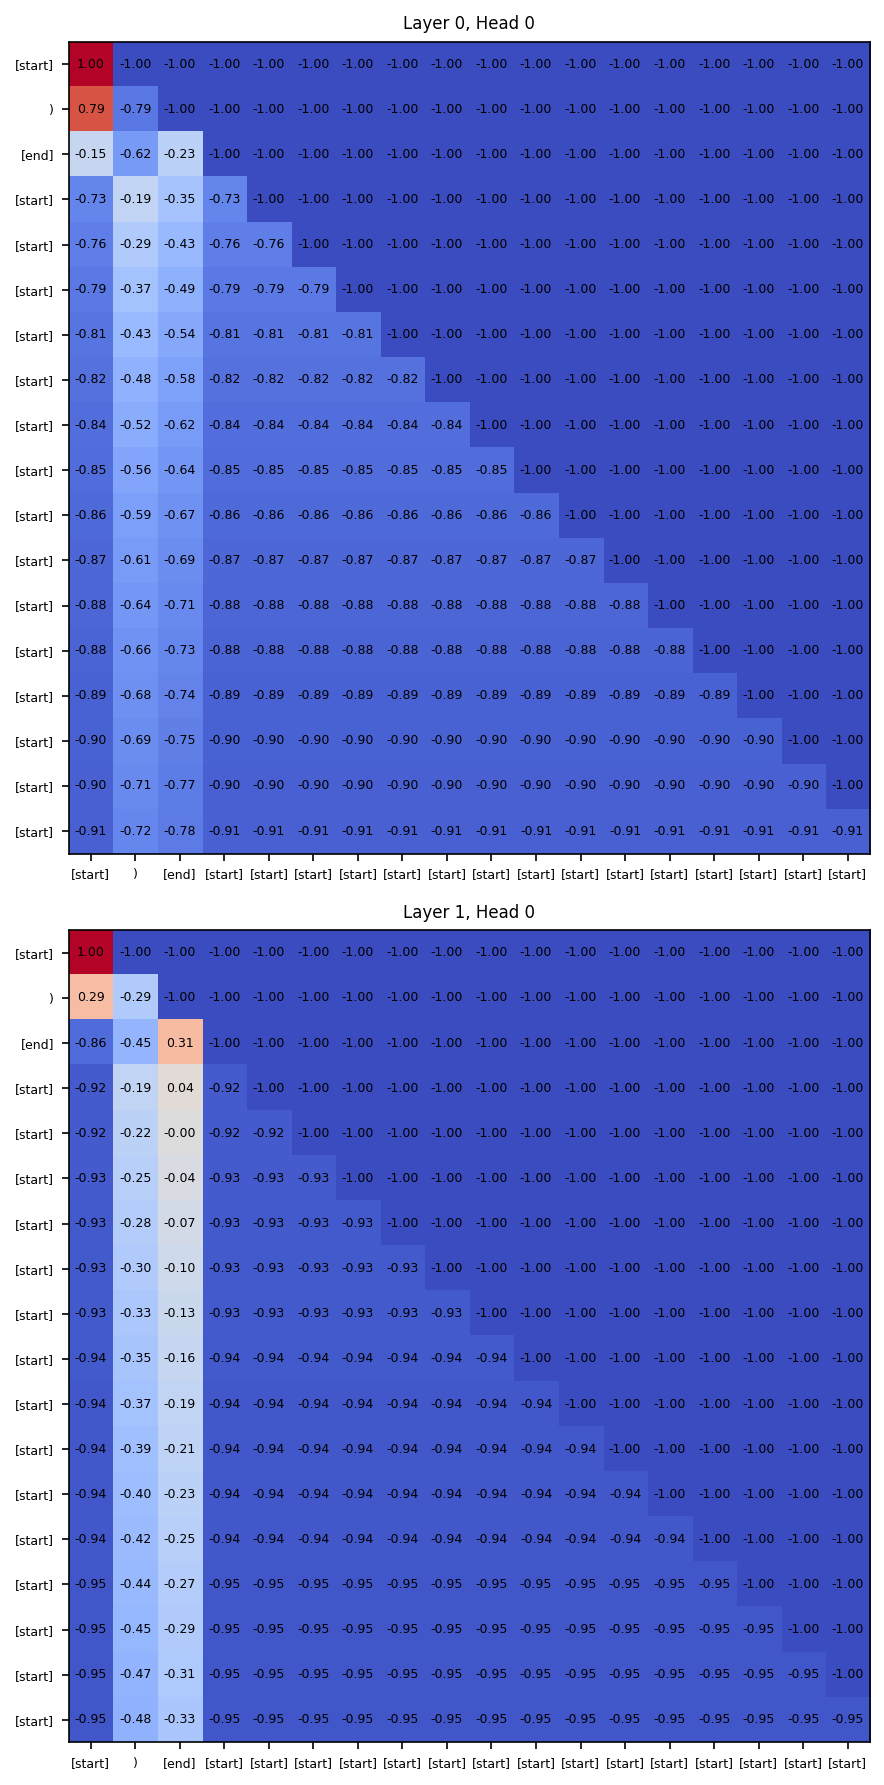

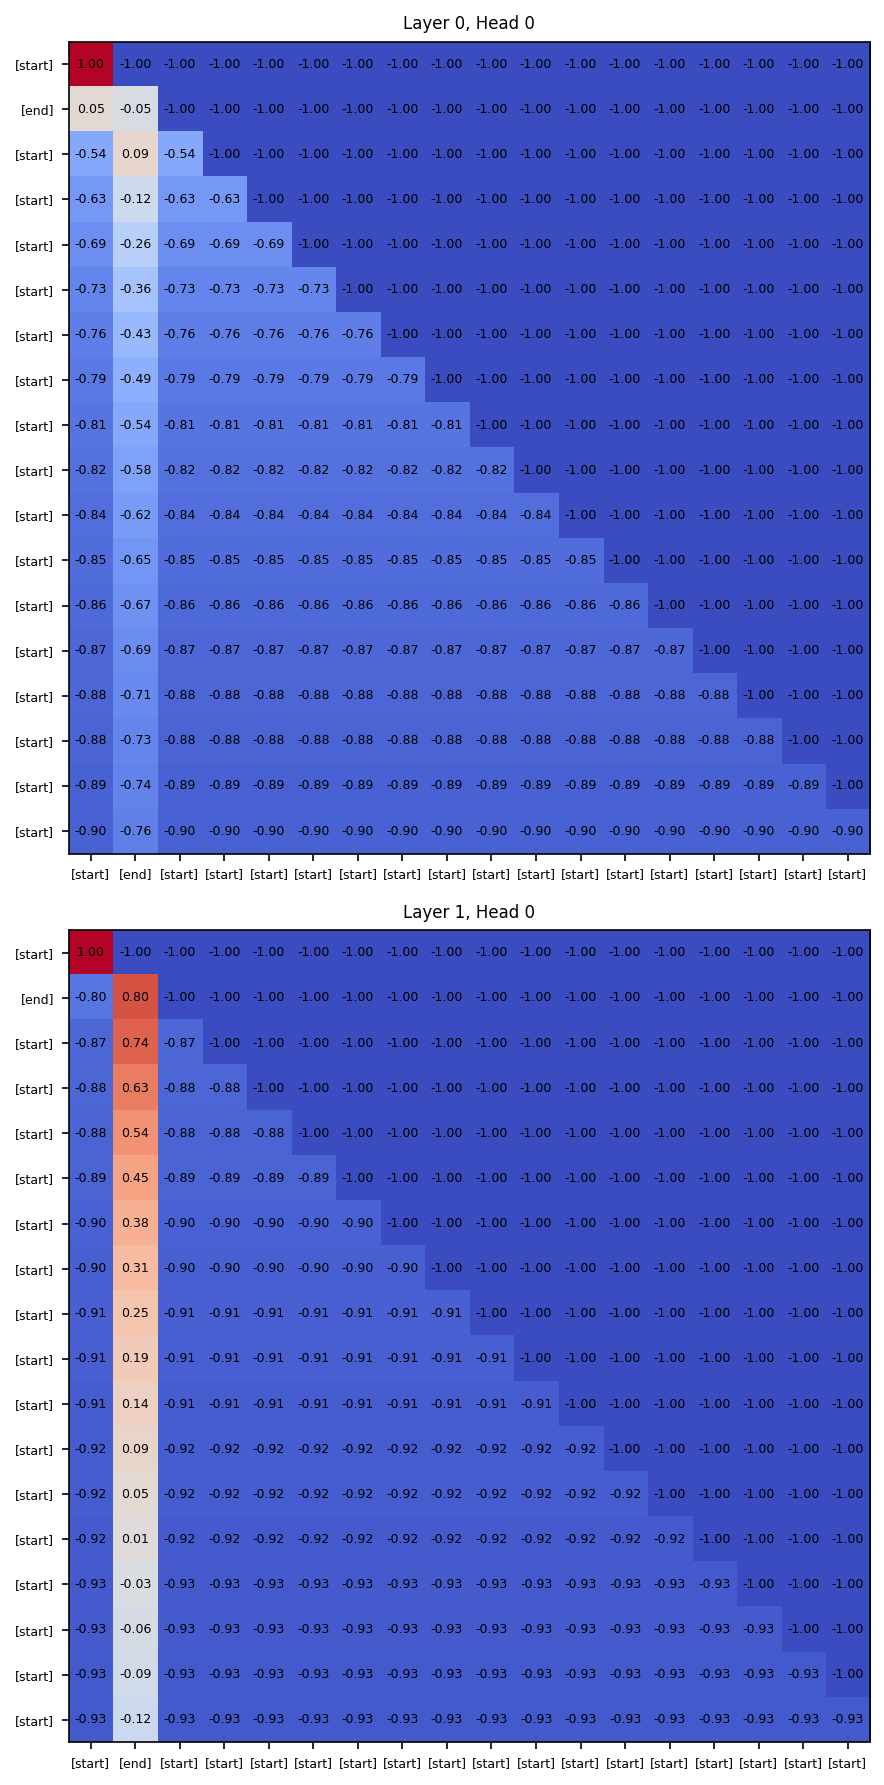

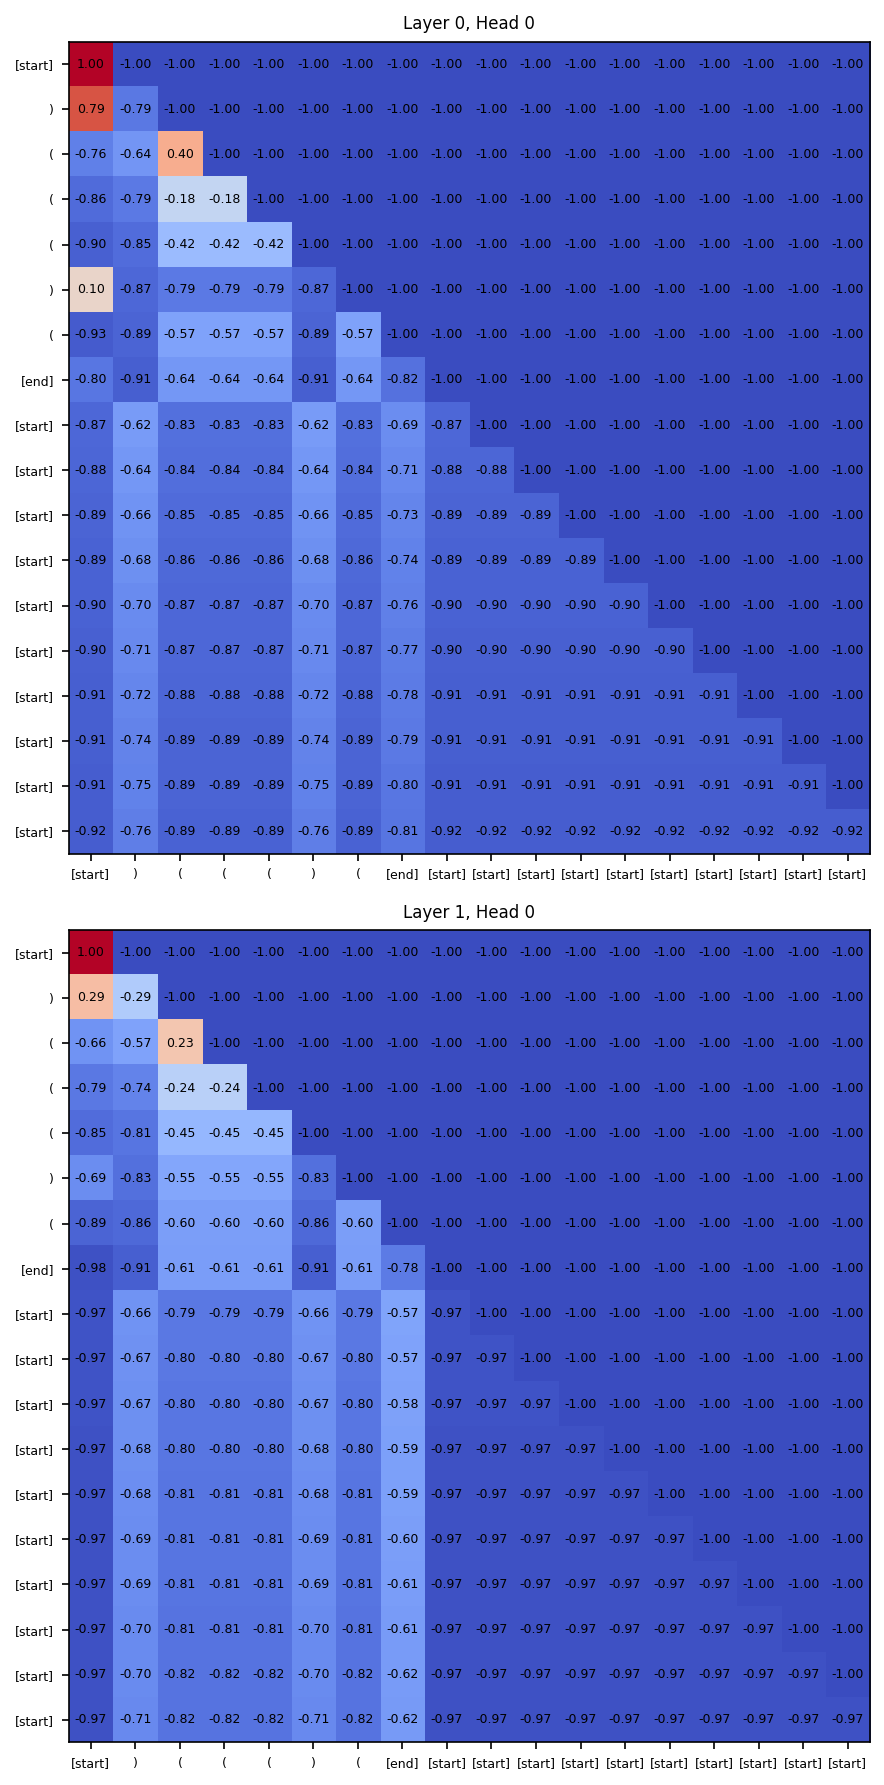

In [32]:
plot_attn_matrices(VOCAB, batch, model_causal, min_max_normalize, causal_mask)

# Hooked Transformer (Bidirectional mask) - Dyck-3 dataset


In [33]:
k = 3

In [34]:
path = generate_dataset(
    n=15_000,
    k=3,
    min_length=0,
    max_length=16,
    balanced=0.5,
)

Generating unbalanced strings: 100%|██████████| 7500/7500 [00:00<00:00, 73868.18it/s]
Saving dataset to data/dyck-3_15000-samples_16-len_p05.jsonl: 100%|██████████| 15000/15000 [00:00<00:00, 619713.56it/s]

Dataset saved to data/dyck-3_15000-samples_16-len_p05.jsonl


In [35]:
VOCAB = "".join(
    ["".join((key, value)) for key, value in list(constants.BRACKETS.items())[:k]]
)
VOCAB

'()[]{}'

In [36]:
dataset_dyck_2 = DyckLanguageDataset(path, VOCAB).to(device)

Loaded 15000 samples from data/dyck-3_15000-samples_16-len_p05.jsonl


Padding strings: 100%|██████████| 15000/15000 [00:00<00:00, 6389859.84it/s]


In [37]:
train_size = int(0.8 * len(dataset_dyck_2))
val_size = int(0.15 * train_size)
test_size = len(dataset_dyck_2) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(
    dataset_dyck_2, [train_size, val_size, test_size]
)

In [38]:
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=True)

In [39]:
model_config = TransformerClassifierConfig(
    vocab_size=len(VOCAB),
    d_model=256,
    n_heads=1,
    dim_ff=512,
    n_layers=1,
    n_classes=2,
    max_seq_len=16,
)

In [40]:
model = TransformerClassifier(model_config).to(device)

In [41]:
crit = torch.nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=1e-5)

In [42]:
train_loss, train_acc, val_loss, val_acc = model.train_model(
    device=device,
    epochs=15,
    optimizer=optimizer,
    criterion=crit,
    train_dataloader=train_dataloader,
    eval_dataloader=val_dataloader,
    use_mask="bidirectional",
)

Epoch 1/15


  0%|          | 0/188 [00:00<?, ?it/s]

Train Loss: 0.3719 | Train Accuracy: 75.17%


  0%|          | 0/29 [00:00<?, ?it/s]

Train Loss: 82.9357 | Train Acc: 80.38%
Val Loss: 9.9121 | Val Acc: 85.83%
Epoch 2/15


  0%|          | 0/188 [00:00<?, ?it/s]

Train Loss: 0.2754 | Train Accuracy: 86.53%


  0%|          | 0/29 [00:00<?, ?it/s]

Train Loss: 50.5555 | Train Acc: 89.59%
Val Loss: 3.2903 | Val Acc: 97.17%
Epoch 3/15


  0%|          | 0/188 [00:00<?, ?it/s]

Train Loss: 0.0351 | Train Accuracy: 97.47%


  0%|          | 0/29 [00:00<?, ?it/s]

Train Loss: 10.0687 | Train Acc: 98.51%
Val Loss: 0.2718 | Val Acc: 100.00%
Epoch 4/15


  0%|          | 0/188 [00:00<?, ?it/s]

Train Loss: 0.0073 | Train Accuracy: 100.00%


  0%|          | 0/29 [00:00<?, ?it/s]

Train Loss: 1.5086 | Train Acc: 99.99%
Val Loss: 0.0669 | Val Acc: 100.00%
Epoch 5/15


  0%|          | 0/188 [00:00<?, ?it/s]

Train Loss: 0.0026 | Train Accuracy: 100.00%


  0%|          | 0/29 [00:00<?, ?it/s]

Train Loss: 0.5961 | Train Acc: 99.99%
Val Loss: 0.0307 | Val Acc: 100.00%
Epoch 6/15


  0%|          | 0/188 [00:00<?, ?it/s]

Train Loss: 0.0015 | Train Accuracy: 100.00%


  0%|          | 0/29 [00:00<?, ?it/s]

Train Loss: 0.3447 | Train Acc: 99.99%
Val Loss: 0.0181 | Val Acc: 100.00%
Epoch 7/15


  0%|          | 0/188 [00:00<?, ?it/s]

Train Loss: 0.0012 | Train Accuracy: 100.00%


  0%|          | 0/29 [00:00<?, ?it/s]

Train Loss: 0.2087 | Train Acc: 99.99%
Val Loss: 0.0107 | Val Acc: 100.00%
Epoch 8/15


  0%|          | 0/188 [00:00<?, ?it/s]

Train Loss: 0.0007 | Train Accuracy: 100.00%


  0%|          | 0/29 [00:00<?, ?it/s]

Train Loss: 0.1315 | Train Acc: 100.00%
Val Loss: 0.0067 | Val Acc: 100.00%
Epoch 9/15


  0%|          | 0/188 [00:00<?, ?it/s]

Train Loss: 0.0006 | Train Accuracy: 100.00%


  0%|          | 0/29 [00:00<?, ?it/s]

Train Loss: 0.0958 | Train Acc: 100.00%
Val Loss: 0.0051 | Val Acc: 100.00%
Epoch 10/15


  0%|          | 0/188 [00:00<?, ?it/s]

Train Loss: 0.0004 | Train Accuracy: 100.00%


  0%|          | 0/29 [00:00<?, ?it/s]

Train Loss: 0.0724 | Train Acc: 100.00%
Val Loss: 0.0037 | Val Acc: 100.00%
Epoch 11/15


  0%|          | 0/188 [00:00<?, ?it/s]

Train Loss: 0.0003 | Train Accuracy: 100.00%


  0%|          | 0/29 [00:00<?, ?it/s]

Train Loss: 0.0568 | Train Acc: 100.00%
Val Loss: 0.0028 | Val Acc: 100.00%
Epoch 12/15


  0%|          | 0/188 [00:00<?, ?it/s]

Train Loss: 0.0002 | Train Accuracy: 100.00%


  0%|          | 0/29 [00:00<?, ?it/s]

Train Loss: 0.0462 | Train Acc: 100.00%
Val Loss: 0.0022 | Val Acc: 100.00%
Epoch 13/15


  0%|          | 0/188 [00:00<?, ?it/s]

Train Loss: 0.0002 | Train Accuracy: 100.00%


  0%|          | 0/29 [00:00<?, ?it/s]

Train Loss: 0.0375 | Train Acc: 100.00%
Val Loss: 0.0018 | Val Acc: 100.00%
Epoch 14/15


  0%|          | 0/188 [00:00<?, ?it/s]

Train Loss: 0.0002 | Train Accuracy: 100.00%


  0%|          | 0/29 [00:00<?, ?it/s]

Train Loss: 0.0337 | Train Acc: 100.00%
Val Loss: 0.0015 | Val Acc: 100.00%
Epoch 15/15


  0%|          | 0/188 [00:00<?, ?it/s]

Train Loss: 0.0001 | Train Accuracy: 100.00%


  0%|          | 0/29 [00:00<?, ?it/s]

Train Loss: 0.0268 | Train Acc: 100.00%
Val Loss: 0.0013 | Val Acc: 100.00%


In [43]:
test_loss, test_acc = model.eval_model(
    device=device,
    test_dataloader=test_dataloader,
    criterion=crit,
    use_mask="bidirectional",
)

  0%|          | 0/150 [00:00<?, ?it/s]

Test Loss: 0.0046 | Test Accuracy: 100.00%
Test Loss: 0.0069 | Test Acc: 100.00%


test/acc,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test/loss,▁▃▃▁▃▂▁▂▁▁▂▄▂▄▄▂█▃▂▃▅▅▆▁▁▄▃▄▄▁▁▃▁▃▄▃▄▃▁▁
test_acc,▁
test_loss,▁
train/acc,▁▄▅▆▆███████████████████████████████████
train/loss,█▅▅▆▄▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val/acc,▁▁▁▇▇▇██████████████████████████████████
val/loss,▅▆█▃▃▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test/acc,100.0
test/loss,3e-05
test_acc,100.0


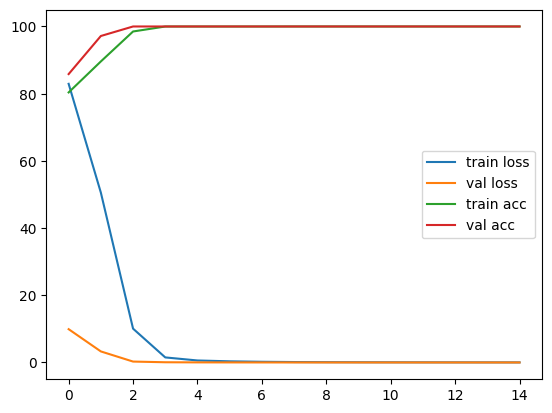

In [44]:
import matplotlib.pyplot as plt

plt.plot(train_loss, label="train loss")
plt.plot(val_loss, label="val loss")
plt.plot(train_acc, label="train acc")
plt.plot(val_acc, label="val acc")
plt.legend()
plt.show()

In [45]:
batch = next(iter(test_dataloader))
batch

[('((((([])))))', '', ')[{[}[(}', ')[{[}[(}', ')', ')', '{()}()', ')[{[}[(}'),
 tensor([1., 1., 0., 0., 0., 0., 1., 0.], device='cuda:0'),
 tensor([[0., 3., 3., 3., 3., 3., 5., 6., 4., 4., 4., 4., 4., 2., 0., 0., 0., 0.],
         [0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 4., 5., 7., 5., 8., 5., 3., 8., 2., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 4., 5., 7., 5., 8., 5., 3., 8., 2., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 4., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 4., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 7., 3., 4., 8., 3., 4., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 4., 5., 7., 5., 8., 5., 3., 8., 2., 0., 0., 0., 0., 0., 0., 0., 0.]],
        device='cuda:0')]

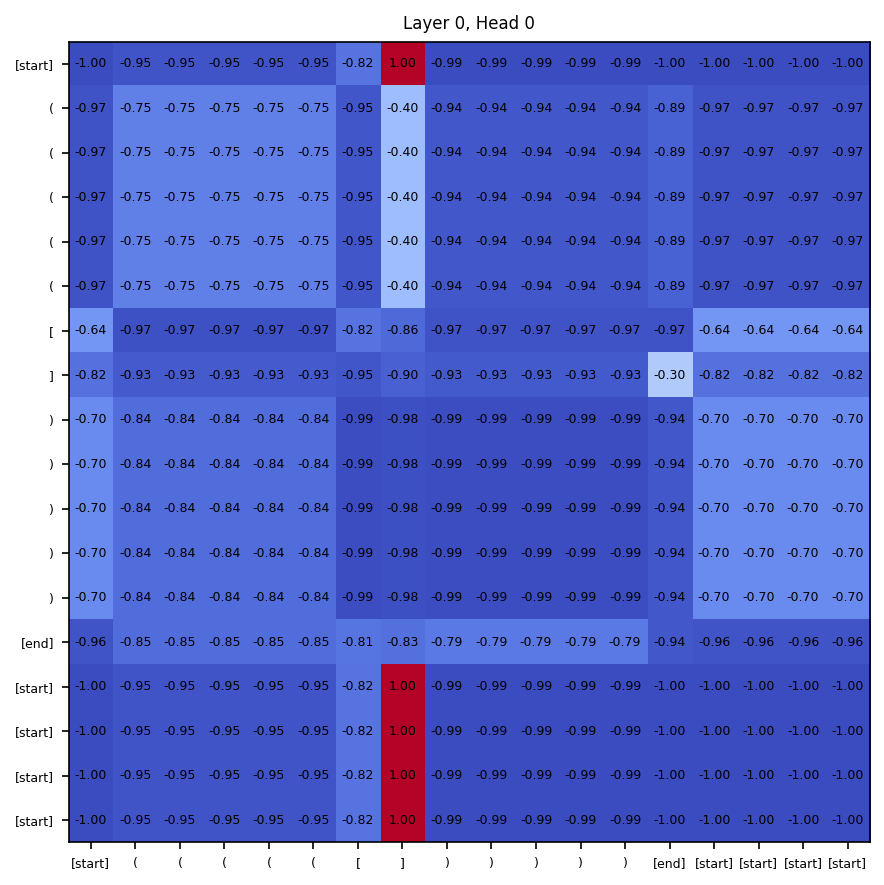

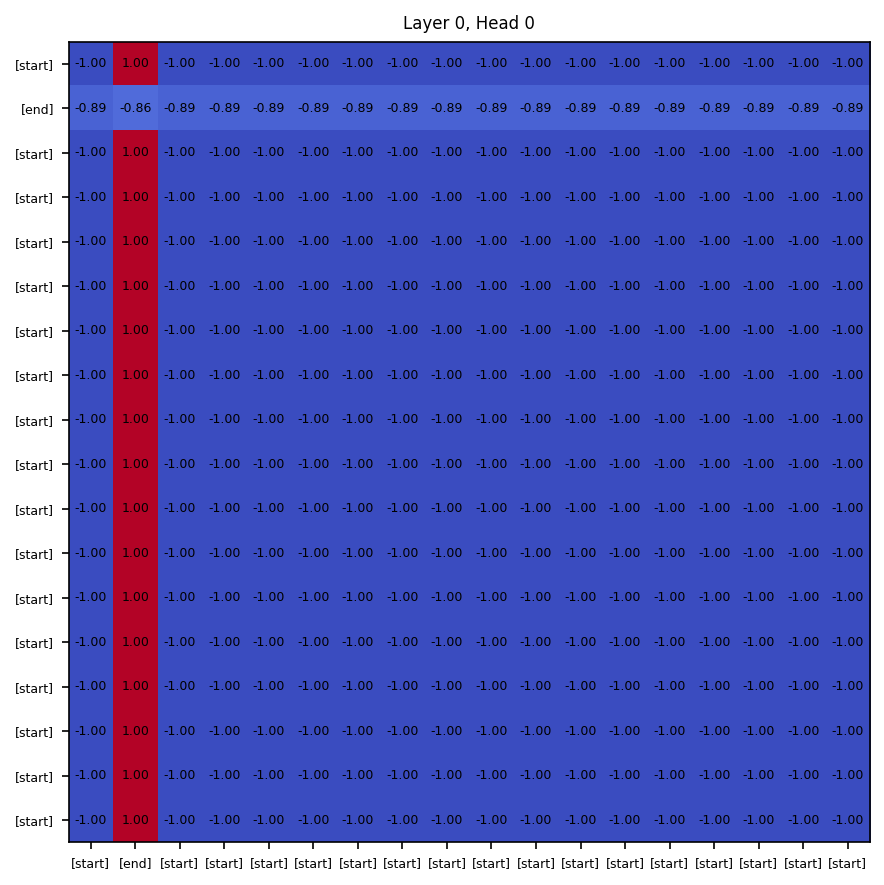

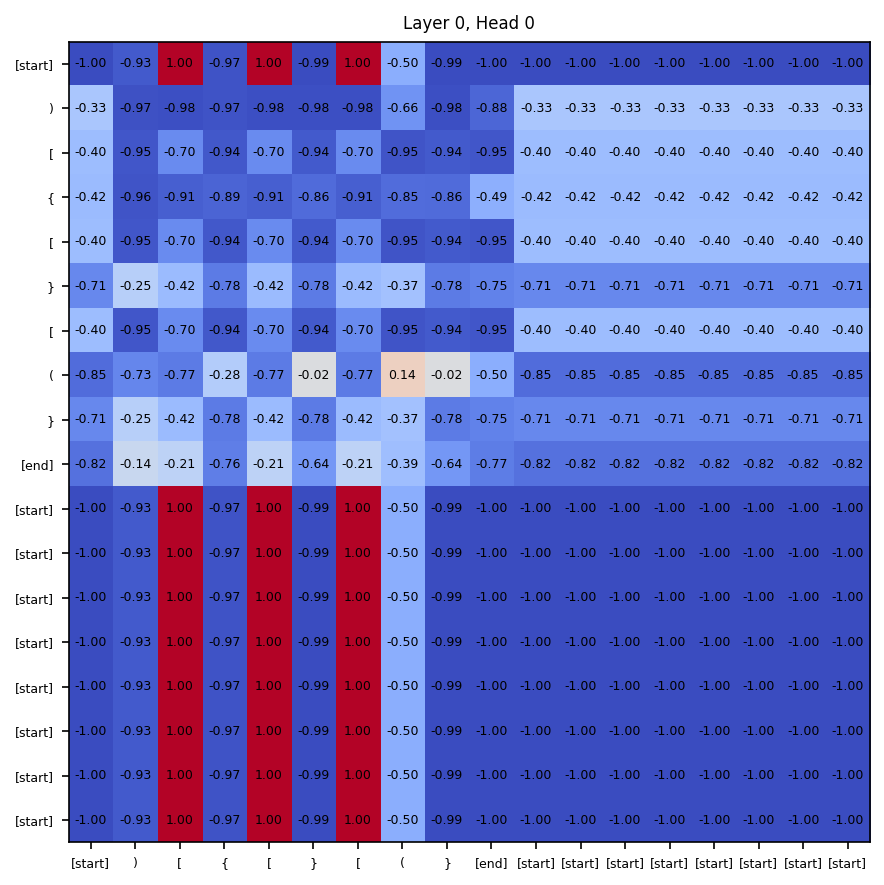

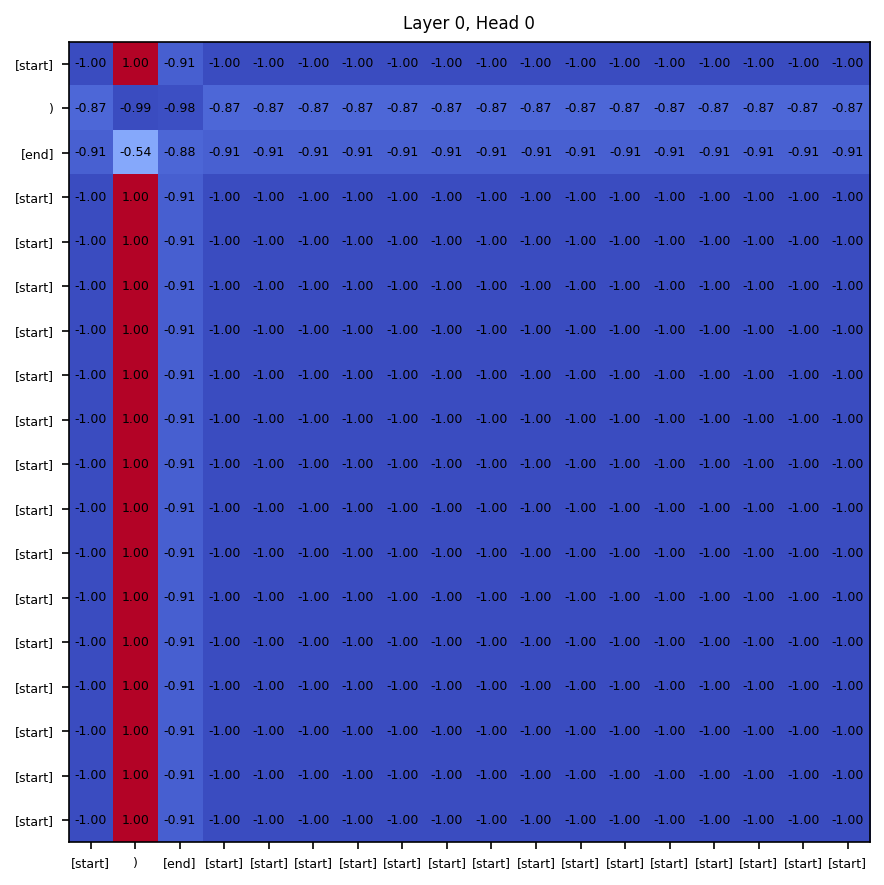

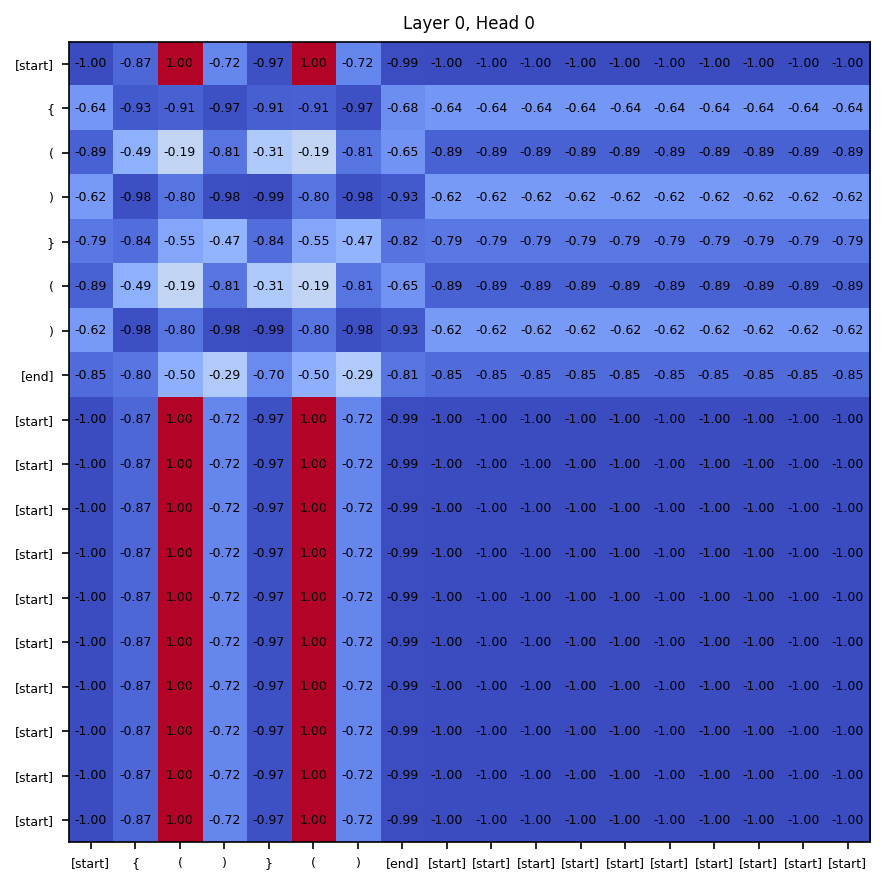

In [46]:
plot_attn_matrices(VOCAB, batch, model, min_max_normalize, pad_token_mask)

# Out of Distribution Dyck-3

In [47]:
k = 3

In [48]:
dyck_3_train_dataset = generate_dataset(
    n=50_000,
    k=3,
    min_length=0,
    max_length=96,
    balanced=0.5,
)

File data/dyck-3_50000-samples_96-len_p05.jsonl already exists.


In [49]:
dyck_3_train_dataset

'data/dyck-3_50000-samples_96-len_p05.jsonl'

In [50]:
VOCAB = "".join(
    ["".join((key, value)) for key, value in list(constants.BRACKETS.items())[:k]]
)
VOCAB

'()[]{}'

In [51]:
dyck_3_train = DyckLanguageDataset(dyck_3_train_dataset, VOCAB).to(device)

train_dataset, val_dataset = random_split(
    dyck_3_train, [0.8, 0.2]
)

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=True)

Loaded 50000 samples from data/dyck-3_50000-samples_96-len_p05.jsonl


Padding strings: 100%|██████████| 50000/50000 [00:00<00:00, 6147842.40it/s]


In [52]:
ood_model_config = TransformerClassifierConfig(
    vocab_size=len(VOCAB),
    d_model=256,
    n_heads=1,
    dim_ff=320,
    n_layers=2,
    n_classes=2,
    max_seq_len=128,
)

ood_model = TransformerClassifier(ood_model_config).to(device)

In [53]:
crit = torch.nn.CrossEntropyLoss()

optimizer = optim.Adam(ood_model.parameters(), lr=1e-4)

In [54]:
train_loss, train_acc, val_loss, val_acc = ood_model.train_model(
    device=device,
    epochs=10,
    optimizer=optimizer,
    criterion=crit,
    train_dataloader=train_dataloader,
    eval_dataloader=val_dataloader,
    use_mask="bidirectional",
)

Epoch 1/10


  0%|          | 0/625 [00:00<?, ?it/s]

Train Loss: 0.0017 | Train Accuracy: 95.66%
Train Loss: 0.0003 | Train Accuracy: 97.83%
Train Loss: 0.2474 | Train Accuracy: 92.70%
Train Loss: 0.0175 | Train Accuracy: 93.98%
Train Loss: 0.0479 | Train Accuracy: 93.59%
Train Loss: 0.0127 | Train Accuracy: 94.57%


  0%|          | 0/157 [00:00<?, ?it/s]

Validation Loss: 0.3080 | Validation Accuracy: 99.95%
Train Loss: 101.8279 | Train Acc: 94.77%
Val Loss: 0.4507 | Val Acc: 99.95%
Epoch 2/10


  0%|          | 0/625 [00:00<?, ?it/s]

Train Loss: 0.0011 | Train Accuracy: 99.97%
Train Loss: 0.0008 | Train Accuracy: 99.95%
Train Loss: 0.0005 | Train Accuracy: 99.97%
Train Loss: 0.0004 | Train Accuracy: 99.97%
Train Loss: 0.0002 | Train Accuracy: 99.98%
Train Loss: 0.0002 | Train Accuracy: 99.98%


  0%|          | 0/157 [00:00<?, ?it/s]

Validation Loss: 0.0053 | Validation Accuracy: 100.00%
Train Loss: 0.8838 | Train Acc: 99.98%
Val Loss: 0.0085 | Val Acc: 100.00%
Epoch 3/10


  0%|          | 0/625 [00:00<?, ?it/s]

Train Loss: 0.0002 | Train Accuracy: 100.00%
Train Loss: 0.0001 | Train Accuracy: 99.98%
Train Loss: 0.0001 | Train Accuracy: 99.99%
Train Loss: 0.0001 | Train Accuracy: 99.99%
Train Loss: 0.0001 | Train Accuracy: 99.99%
Train Loss: 0.0001 | Train Accuracy: 99.99%


  0%|          | 0/157 [00:00<?, ?it/s]

Validation Loss: 0.0018 | Validation Accuracy: 100.00%
Train Loss: 0.1544 | Train Acc: 100.00%
Val Loss: 0.0028 | Val Acc: 100.00%
Epoch 4/10


  0%|          | 0/625 [00:00<?, ?it/s]

Train Loss: 0.0001 | Train Accuracy: 100.00%
Train Loss: 0.0001 | Train Accuracy: 100.00%
Train Loss: 0.0001 | Train Accuracy: 100.00%
Train Loss: 0.0001 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%


  0%|          | 0/157 [00:00<?, ?it/s]

Validation Loss: 0.0010 | Validation Accuracy: 100.00%
Train Loss: 0.0348 | Train Acc: 100.00%
Val Loss: 0.0016 | Val Acc: 100.00%
Epoch 5/10


  0%|          | 0/625 [00:00<?, ?it/s]

Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%


  0%|          | 0/157 [00:00<?, ?it/s]

Validation Loss: 0.0007 | Validation Accuracy: 100.00%
Train Loss: 0.0232 | Train Acc: 100.00%
Val Loss: 0.0011 | Val Acc: 100.00%
Epoch 6/10


  0%|          | 0/625 [00:00<?, ?it/s]

Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%


  0%|          | 0/157 [00:00<?, ?it/s]

Validation Loss: 0.0005 | Validation Accuracy: 100.00%
Train Loss: 0.0163 | Train Acc: 100.00%
Val Loss: 0.0008 | Val Acc: 100.00%
Epoch 7/10


  0%|          | 0/625 [00:00<?, ?it/s]

Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%


  0%|          | 0/157 [00:00<?, ?it/s]

Validation Loss: 0.0003 | Validation Accuracy: 100.00%
Train Loss: 0.0121 | Train Acc: 100.00%
Val Loss: 0.0005 | Val Acc: 100.00%
Epoch 8/10


  0%|          | 0/625 [00:00<?, ?it/s]

Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%


  0%|          | 0/157 [00:00<?, ?it/s]

Validation Loss: 0.0003 | Validation Accuracy: 100.00%
Train Loss: 0.0085 | Train Acc: 100.00%
Val Loss: 0.0004 | Val Acc: 100.00%
Epoch 9/10


  0%|          | 0/625 [00:00<?, ?it/s]

Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%


  0%|          | 0/157 [00:00<?, ?it/s]

Validation Loss: 0.0002 | Validation Accuracy: 100.00%
Train Loss: 0.0066 | Train Acc: 100.00%
Val Loss: 0.0003 | Val Acc: 100.00%
Epoch 10/10


  0%|          | 0/625 [00:00<?, ?it/s]

Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%


  0%|          | 0/157 [00:00<?, ?it/s]

Validation Loss: 0.0002 | Validation Accuracy: 100.00%
Train Loss: 0.0053 | Train Acc: 100.00%
Val Loss: 0.0003 | Val Acc: 100.00%


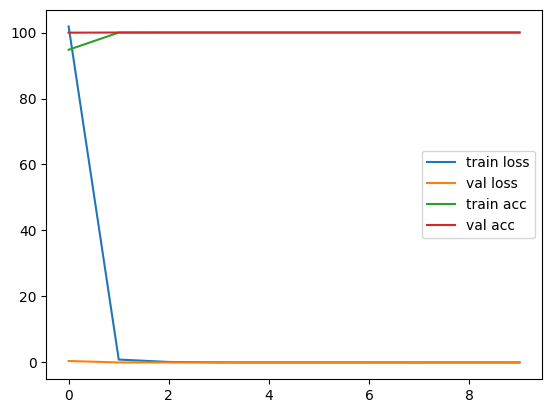

In [55]:
import matplotlib.pyplot as plt

plt.plot(train_loss, label="train loss")
plt.plot(val_loss, label="val loss")
plt.plot(train_acc, label="train acc")
plt.plot(val_acc, label="val acc")
plt.legend()
plt.show()

In [56]:
dyck_3_test_dataset = generate_dataset(
    n=10_000,
    k=3,
    min_length=32,
    max_length=128,
    balanced=0.5,
)

File data/dyck-3_10000-samples_128-len_p05.jsonl already exists.


In [57]:
dyck_3_test = DyckLanguageDataset(dyck_3_test_dataset, VOCAB).to(device)
test_dataloader = DataLoader(dyck_3_test, batch_size=8, shuffle=True)


Loaded 10000 samples from data/dyck-3_10000-samples_128-len_p05.jsonl


Padding strings: 100%|██████████| 10000/10000 [00:00<00:00, 5789239.48it/s]


In [58]:
test_loss, test_acc = ood_model.eval_model(
    device=device,
    test_dataloader=test_dataloader,
    criterion=crit,
    use_mask="bidirectional",
)

  0%|          | 0/1250 [00:00<?, ?it/s]

Test Loss: 11.4002 | Test Accuracy: 97.25%
Test Loss: 19.1472 | Test Accuracy: 97.44%
Test Loss: 26.9823 | Test Accuracy: 97.71%
Test Loss: 40.4951 | Test Accuracy: 97.56%
Test Loss: 56.2978 | Test Accuracy: 97.35%
Test Loss: 67.2218 | Test Accuracy: 97.35%
Test Loss: 78.4054 | Test Accuracy: 97.32%
Test Loss: 88.3879 | Test Accuracy: 97.33%
Test Loss: 99.2272 | Test Accuracy: 97.33%
Test Loss: 111.3582 | Test Accuracy: 97.38%
Test Loss: 123.4019 | Test Accuracy: 97.36%
Test Loss: 139.5831 | Test Accuracy: 97.31%
Test Loss: 148.7596 | Test Acc: 97.24%


test/acc,▁▅▁▅▅▆▆█▇███▇▇▆▅▅▆▅▅▅▆▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▄
test/loss,▁▁▁▂▄▃▂▁▁▁▁▁▁▃▁▁▁▁▁▃▁▁▁▄▁█▁▁▁▁▁▁▅▁▁▁▁▁▁▁
test_acc,▁
test_loss,▁
train/acc,▂▆▁▂████████████████████████████████████
train/loss,▁▁█▇▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val/acc,▁▃▅▄████████████████████████████████████
val/loss,▆█▇▇▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test/acc,97.24
test/loss,0.01818
test_acc,97.24


# Long Context Dyck-3

We will now train a hooked transformer with a bidirectional mask, no PE and a max sequence length of 4096.

In [59]:
k = 3
VOCAB = "".join(
    ["".join((key, value)) for key, value in list(constants.BRACKETS.items())[:k]]
)
VOCAB

'()[]{}'

In [60]:
long_ctx_file = generate_dataset(
    n=500_000,
    k=k,
    min_length=0,
    max_length=4096,
    balanced=0.5,
)

Generating unbalanced strings: 100%|██████████| 250000/250000 [04:31<00:00, 921.33it/s]
Saving dataset to data/dyck-3_500000-samples_4096-len_p05.jsonl: 100%|██████████| 500000/500000 [00:02<00:00, 174482.88it/s]

Dataset saved to data/dyck-3_500000-samples_4096-len_p05.jsonl


In [61]:
long_ctx_dataset = DyckLanguageDataset(long_ctx_file, VOCAB).to(device)

Loaded 500000 samples from data/dyck-3_500000-samples_4096-len_p05.jsonl


Padding strings: 100%|██████████| 500000/500000 [00:00<00:00, 4089067.75it/s]


In [62]:
from torch.utils.data import random_split

train_size = int(0.8 * len(dataset))
val_size = int(0.15 * train_size)
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(
    dataset, [train_size, val_size, test_size]
)

In [63]:
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=4, shuffle=True)

In [64]:
long_ctx_model_config = TransformerClassifierConfig(
    vocab_size=len(VOCAB),
    d_model=384,
    n_heads=1,
    dim_ff=768,
    n_layers=2,
    n_classes=2,
    max_seq_len=4096,
)

long_ctx_model = TransformerClassifier(long_ctx_model_config).to(device)

In [65]:
crit = torch.nn.CrossEntropyLoss()

optimizer = optim.Adam(long_ctx_model.parameters(), lr=1e-5)

In [66]:
train_loss, train_acc, val_loss, val_acc = long_ctx_model.train_model(
    device=device,
    epochs=100,
    optimizer=optimizer,
    criterion=crit,
    train_dataloader=train_dataloader,
    eval_dataloader=val_dataloader,
    use_mask="bidirectional",
)

Epoch 1/100


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.3344 | Train Accuracy: 69.88%
Train Loss: 0.4050 | Train Accuracy: 78.77%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 17.3014 | Validation Accuracy: 96.88%
Train Loss: 102.9751 | Train Acc: 81.42%
Val Loss: 24.8526 | Val Acc: 97.17%
Epoch 2/100


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.1361 | Train Accuracy: 95.38%
Train Loss: 0.2463 | Train Accuracy: 95.78%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 9.2589 | Validation Accuracy: 97.00%
Train Loss: 33.1440 | Train Acc: 96.12%
Val Loss: 13.2425 | Val Acc: 97.17%
Epoch 3/100


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.2250 | Train Accuracy: 97.06%
Train Loss: 0.0269 | Train Accuracy: 96.27%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 8.4396 | Validation Accuracy: 97.00%
Train Loss: 28.1760 | Train Acc: 96.35%
Val Loss: 12.2947 | Val Acc: 97.17%
Epoch 4/100


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.1763 | Train Accuracy: 97.25%
Train Loss: 0.0308 | Train Accuracy: 97.28%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 7.5031 | Validation Accuracy: 97.38%
Train Loss: 22.5648 | Train Acc: 97.20%
Val Loss: 11.7385 | Val Acc: 97.17%
Epoch 5/100


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.0135 | Train Accuracy: 97.88%
Train Loss: 0.0044 | Train Accuracy: 98.92%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 0.1137 | Validation Accuracy: 100.00%
Train Loss: 7.7845 | Train Acc: 99.14%
Val Loss: 0.1638 | Val Acc: 100.00%
Epoch 6/100


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.0025 | Train Accuracy: 99.97%
Train Loss: 0.0028 | Train Accuracy: 99.83%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 0.0373 | Validation Accuracy: 100.00%
Train Loss: 1.9028 | Train Acc: 99.84%
Val Loss: 0.0553 | Val Acc: 100.00%
Epoch 7/100


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.0012 | Train Accuracy: 100.00%
Train Loss: 0.0062 | Train Accuracy: 99.94%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 0.0543 | Validation Accuracy: 100.00%
Train Loss: 2.5281 | Train Acc: 99.79%
Val Loss: 0.0854 | Val Acc: 100.00%
Epoch 8/100


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.0010 | Train Accuracy: 99.94%
Train Loss: 0.0014 | Train Accuracy: 99.97%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 0.0132 | Validation Accuracy: 100.00%
Train Loss: 0.7394 | Train Acc: 99.98%
Val Loss: 0.0195 | Val Acc: 100.00%
Epoch 9/100


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.0008 | Train Accuracy: 100.00%
Train Loss: 0.0010 | Train Accuracy: 99.94%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 0.0091 | Validation Accuracy: 100.00%
Train Loss: 0.5746 | Train Acc: 99.95%
Val Loss: 0.0137 | Val Acc: 100.00%
Epoch 10/100


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.0007 | Train Accuracy: 100.00%
Train Loss: 0.0010 | Train Accuracy: 99.98%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 0.0074 | Validation Accuracy: 100.00%
Train Loss: 0.3155 | Train Acc: 99.99%
Val Loss: 0.0110 | Val Acc: 100.00%
Epoch 11/100


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.0005 | Train Accuracy: 100.00%
Train Loss: 0.0002 | Train Accuracy: 99.97%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 0.0057 | Validation Accuracy: 100.00%
Train Loss: 0.5213 | Train Acc: 99.96%
Val Loss: 0.0083 | Val Acc: 100.00%
Epoch 12/100


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.0012 | Train Accuracy: 99.97%
Train Loss: 0.0002 | Train Accuracy: 99.98%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 0.0038 | Validation Accuracy: 100.00%
Train Loss: 0.1788 | Train Acc: 99.99%
Val Loss: 0.0058 | Val Acc: 100.00%
Epoch 13/100


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.0004 | Train Accuracy: 99.97%
Train Loss: 0.0009 | Train Accuracy: 99.98%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 0.0040 | Validation Accuracy: 100.00%
Train Loss: 0.1970 | Train Acc: 99.99%
Val Loss: 0.0064 | Val Acc: 100.00%
Epoch 14/100


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.0032 | Train Accuracy: 97.62%
Train Loss: 0.0008 | Train Accuracy: 98.81%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 0.0103 | Validation Accuracy: 100.00%
Train Loss: 11.1753 | Train Acc: 99.05%
Val Loss: 0.0157 | Val Acc: 100.00%
Epoch 15/100


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.0006 | Train Accuracy: 100.00%
Train Loss: 0.0009 | Train Accuracy: 99.98%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 0.0065 | Validation Accuracy: 100.00%
Train Loss: 0.2549 | Train Acc: 99.99%
Val Loss: 0.0098 | Val Acc: 100.00%
Epoch 16/100


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.0008 | Train Accuracy: 100.00%
Train Loss: 0.0004 | Train Accuracy: 100.00%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 0.0050 | Validation Accuracy: 100.00%
Train Loss: 0.2243 | Train Acc: 99.99%
Val Loss: 0.0074 | Val Acc: 100.00%
Epoch 17/100


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.0006 | Train Accuracy: 100.00%
Train Loss: 0.0002 | Train Accuracy: 99.98%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 0.0042 | Validation Accuracy: 100.00%
Train Loss: 0.1785 | Train Acc: 99.99%
Val Loss: 0.0061 | Val Acc: 100.00%
Epoch 18/100


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.0003 | Train Accuracy: 100.00%
Train Loss: 0.0007 | Train Accuracy: 100.00%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 0.0032 | Validation Accuracy: 100.00%
Train Loss: 0.1447 | Train Acc: 99.99%
Val Loss: 0.0047 | Val Acc: 100.00%
Epoch 19/100


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.0016 | Train Accuracy: 99.97%
Train Loss: 0.0002 | Train Accuracy: 99.98%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 0.0024 | Validation Accuracy: 100.00%
Train Loss: 0.1268 | Train Acc: 99.99%
Val Loss: 0.0037 | Val Acc: 100.00%
Epoch 20/100


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.0002 | Train Accuracy: 100.00%
Train Loss: 0.0002 | Train Accuracy: 100.00%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 0.0020 | Validation Accuracy: 100.00%
Train Loss: 0.0876 | Train Acc: 99.99%
Val Loss: 0.0031 | Val Acc: 100.00%
Epoch 21/100


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.0004 | Train Accuracy: 100.00%
Train Loss: 0.0001 | Train Accuracy: 100.00%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 0.0017 | Validation Accuracy: 100.00%
Train Loss: 0.0529 | Train Acc: 100.00%
Val Loss: 0.0025 | Val Acc: 100.00%
Epoch 22/100


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.0001 | Train Accuracy: 100.00%
Train Loss: 0.0001 | Train Accuracy: 100.00%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 0.0012 | Validation Accuracy: 100.00%
Train Loss: 0.0457 | Train Acc: 100.00%
Val Loss: 0.0020 | Val Acc: 100.00%
Epoch 23/100


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.0001 | Train Accuracy: 100.00%
Train Loss: 0.0001 | Train Accuracy: 100.00%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 0.0011 | Validation Accuracy: 100.00%
Train Loss: 0.0628 | Train Acc: 100.00%
Val Loss: 0.0016 | Val Acc: 100.00%
Epoch 24/100


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.0001 | Train Accuracy: 100.00%
Train Loss: 0.0001 | Train Accuracy: 100.00%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 0.0012 | Validation Accuracy: 100.00%
Train Loss: 0.0405 | Train Acc: 100.00%
Val Loss: 0.0017 | Val Acc: 100.00%
Epoch 25/100


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.0001 | Train Accuracy: 100.00%
Train Loss: 0.0001 | Train Accuracy: 100.00%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 0.0009 | Validation Accuracy: 100.00%
Train Loss: 0.0472 | Train Acc: 100.00%
Val Loss: 0.0013 | Val Acc: 100.00%
Epoch 26/100


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 0.0007 | Validation Accuracy: 100.00%
Train Loss: 0.0251 | Train Acc: 100.00%
Val Loss: 0.0010 | Val Acc: 100.00%
Epoch 27/100


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.0001 | Train Accuracy: 100.00%
Train Loss: 0.0008 | Train Accuracy: 99.16%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 0.0078 | Validation Accuracy: 100.00%
Train Loss: 7.1472 | Train Acc: 99.33%
Val Loss: 0.0122 | Val Acc: 100.00%
Epoch 28/100


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.0004 | Train Accuracy: 100.00%
Train Loss: 0.0003 | Train Accuracy: 100.00%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 0.0039 | Validation Accuracy: 100.00%
Train Loss: 0.1324 | Train Acc: 100.00%
Val Loss: 0.0055 | Val Acc: 100.00%
Epoch 29/100


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.0005 | Train Accuracy: 100.00%
Train Loss: 0.0002 | Train Accuracy: 99.98%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 0.0021 | Validation Accuracy: 100.00%
Train Loss: 0.1826 | Train Acc: 99.99%
Val Loss: 0.0033 | Val Acc: 100.00%
Epoch 30/100


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.0041 | Train Accuracy: 100.00%
Train Loss: 0.0002 | Train Accuracy: 100.00%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 0.0016 | Validation Accuracy: 100.00%
Train Loss: 0.0649 | Train Acc: 100.00%
Val Loss: 0.0024 | Val Acc: 100.00%
Epoch 31/100


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.0001 | Train Accuracy: 100.00%
Train Loss: 0.0001 | Train Accuracy: 100.00%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 0.0014 | Validation Accuracy: 100.00%
Train Loss: 0.0472 | Train Acc: 100.00%
Val Loss: 0.0020 | Val Acc: 100.00%
Epoch 32/100


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.0001 | Train Accuracy: 100.00%
Train Loss: 0.0001 | Train Accuracy: 100.00%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 0.0011 | Validation Accuracy: 100.00%
Train Loss: 0.0290 | Train Acc: 100.00%
Val Loss: 0.0017 | Val Acc: 100.00%
Epoch 33/100


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.0001 | Train Accuracy: 99.91%
Train Loss: 0.0002 | Train Accuracy: 99.52%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 0.0032 | Validation Accuracy: 100.00%
Train Loss: 3.4683 | Train Acc: 99.61%
Val Loss: 0.0047 | Val Acc: 100.00%
Epoch 34/100


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.0002 | Train Accuracy: 100.00%
Train Loss: 0.0001 | Train Accuracy: 100.00%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 0.0020 | Validation Accuracy: 100.00%
Train Loss: 0.0939 | Train Acc: 99.99%
Val Loss: 0.0029 | Val Acc: 100.00%
Epoch 35/100


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.0002 | Train Accuracy: 100.00%
Train Loss: 0.0001 | Train Accuracy: 100.00%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 0.0015 | Validation Accuracy: 100.00%
Train Loss: 0.0594 | Train Acc: 100.00%
Val Loss: 0.0022 | Val Acc: 100.00%
Epoch 36/100


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.0001 | Train Accuracy: 100.00%
Train Loss: 0.0001 | Train Accuracy: 100.00%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 0.0012 | Validation Accuracy: 100.00%
Train Loss: 0.0423 | Train Acc: 100.00%
Val Loss: 0.0018 | Val Acc: 100.00%
Epoch 37/100


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.0001 | Train Accuracy: 100.00%
Train Loss: 0.0001 | Train Accuracy: 100.00%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 0.0010 | Validation Accuracy: 100.00%
Train Loss: 0.0350 | Train Acc: 100.00%
Val Loss: 0.0015 | Val Acc: 100.00%
Epoch 38/100


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.0001 | Train Accuracy: 100.00%
Train Loss: 0.0001 | Train Accuracy: 100.00%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 0.0009 | Validation Accuracy: 100.00%
Train Loss: 0.0245 | Train Acc: 100.00%
Val Loss: 0.0013 | Val Acc: 100.00%
Epoch 39/100


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.0001 | Train Accuracy: 100.00%
Train Loss: 0.0001 | Train Accuracy: 100.00%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 0.0007 | Validation Accuracy: 100.00%
Train Loss: 0.0215 | Train Acc: 100.00%
Val Loss: 0.0011 | Val Acc: 100.00%
Epoch 40/100


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.0001 | Train Accuracy: 100.00%
Train Loss: 0.0001 | Train Accuracy: 100.00%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 0.0007 | Validation Accuracy: 100.00%
Train Loss: 0.0444 | Train Acc: 100.00%
Val Loss: 0.0011 | Val Acc: 100.00%
Epoch 41/100


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.0001 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 0.0006 | Validation Accuracy: 100.00%
Train Loss: 0.0201 | Train Acc: 100.00%
Val Loss: 0.0009 | Val Acc: 100.00%
Epoch 42/100


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.0001 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 0.0005 | Validation Accuracy: 100.00%
Train Loss: 0.0139 | Train Acc: 100.00%
Val Loss: 0.0007 | Val Acc: 100.00%
Epoch 43/100


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.0001 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 0.0004 | Validation Accuracy: 100.00%
Train Loss: 0.0142 | Train Acc: 100.00%
Val Loss: 0.0006 | Val Acc: 100.00%
Epoch 44/100


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.0001 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 0.0004 | Validation Accuracy: 100.00%
Train Loss: 0.0117 | Train Acc: 100.00%
Val Loss: 0.0006 | Val Acc: 100.00%
Epoch 45/100


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 0.0003 | Validation Accuracy: 100.00%
Train Loss: 0.0106 | Train Acc: 100.00%
Val Loss: 0.0005 | Val Acc: 100.00%
Epoch 46/100


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 0.0003 | Validation Accuracy: 100.00%
Train Loss: 0.0079 | Train Acc: 100.00%
Val Loss: 0.0004 | Val Acc: 100.00%
Epoch 47/100


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 0.0002 | Validation Accuracy: 100.00%
Train Loss: 0.0107 | Train Acc: 100.00%
Val Loss: 0.0003 | Val Acc: 100.00%
Epoch 48/100


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 0.0002 | Validation Accuracy: 100.00%
Train Loss: 0.0067 | Train Acc: 100.00%
Val Loss: 0.0003 | Val Acc: 100.00%
Epoch 49/100


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 0.0002 | Validation Accuracy: 100.00%
Train Loss: 0.0057 | Train Acc: 100.00%
Val Loss: 0.0003 | Val Acc: 100.00%
Epoch 50/100


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 0.0001 | Validation Accuracy: 100.00%
Train Loss: 0.0067 | Train Acc: 100.00%
Val Loss: 0.0002 | Val Acc: 100.00%
Epoch 51/100


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 0.0001 | Validation Accuracy: 100.00%
Train Loss: 0.0038 | Train Acc: 100.00%
Val Loss: 0.0002 | Val Acc: 100.00%
Epoch 52/100


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 0.0001 | Validation Accuracy: 100.00%
Train Loss: 0.0034 | Train Acc: 100.00%
Val Loss: 0.0002 | Val Acc: 100.00%
Epoch 53/100


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 0.0001 | Validation Accuracy: 100.00%
Train Loss: 0.0042 | Train Acc: 100.00%
Val Loss: 0.0001 | Val Acc: 100.00%
Epoch 54/100


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 0.0001 | Validation Accuracy: 100.00%
Train Loss: 0.0025 | Train Acc: 100.00%
Val Loss: 0.0001 | Val Acc: 100.00%
Epoch 55/100


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 0.0001 | Validation Accuracy: 100.00%
Train Loss: 0.0049 | Train Acc: 100.00%
Val Loss: 0.0001 | Val Acc: 100.00%
Epoch 56/100


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 0.0001 | Validation Accuracy: 100.00%
Train Loss: 0.0018 | Train Acc: 100.00%
Val Loss: 0.0001 | Val Acc: 100.00%
Epoch 57/100


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 0.0001 | Validation Accuracy: 100.00%
Train Loss: 0.0018 | Train Acc: 100.00%
Val Loss: 0.0001 | Val Acc: 100.00%
Epoch 58/100


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 0.0001 | Validation Accuracy: 100.00%
Train Loss: 0.0020 | Train Acc: 100.00%
Val Loss: 0.0001 | Val Acc: 100.00%
Epoch 59/100


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 0.0000 | Validation Accuracy: 100.00%
Train Loss: 0.0013 | Train Acc: 100.00%
Val Loss: 0.0001 | Val Acc: 100.00%
Epoch 60/100


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 0.0000 | Validation Accuracy: 100.00%
Train Loss: 0.0010 | Train Acc: 100.00%
Val Loss: 0.0001 | Val Acc: 100.00%
Epoch 61/100


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 0.0000 | Validation Accuracy: 100.00%
Train Loss: 0.0010 | Train Acc: 100.00%
Val Loss: 0.0001 | Val Acc: 100.00%
Epoch 62/100


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 0.0000 | Validation Accuracy: 100.00%
Train Loss: 0.0009 | Train Acc: 100.00%
Val Loss: 0.0001 | Val Acc: 100.00%
Epoch 63/100


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 0.0000 | Validation Accuracy: 100.00%
Train Loss: 0.0008 | Train Acc: 100.00%
Val Loss: 0.0000 | Val Acc: 100.00%
Epoch 64/100


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 0.0000 | Validation Accuracy: 100.00%
Train Loss: 0.0007 | Train Acc: 100.00%
Val Loss: 0.0000 | Val Acc: 100.00%
Epoch 65/100


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.0008 | Train Accuracy: 97.97%
Train Loss: 0.0002 | Train Accuracy: 98.98%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 0.0032 | Validation Accuracy: 100.00%
Train Loss: 13.0528 | Train Acc: 99.19%
Val Loss: 0.0050 | Val Acc: 100.00%
Epoch 66/100


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.0008 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 0.0015 | Validation Accuracy: 100.00%
Train Loss: 0.0771 | Train Acc: 100.00%
Val Loss: 0.0021 | Val Acc: 100.00%
Epoch 67/100


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.0001 | Train Accuracy: 100.00%
Train Loss: 0.0001 | Train Accuracy: 100.00%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 0.0009 | Validation Accuracy: 100.00%
Train Loss: 0.0469 | Train Acc: 100.00%
Val Loss: 0.0013 | Val Acc: 100.00%
Epoch 68/100


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.0003 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 0.0007 | Validation Accuracy: 100.00%
Train Loss: 0.0287 | Train Acc: 100.00%
Val Loss: 0.0010 | Val Acc: 100.00%
Epoch 69/100


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.0002 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 0.0005 | Validation Accuracy: 100.00%
Train Loss: 0.0224 | Train Acc: 100.00%
Val Loss: 0.0007 | Val Acc: 100.00%
Epoch 70/100


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0001 | Train Accuracy: 100.00%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 0.0004 | Validation Accuracy: 100.00%
Train Loss: 0.0186 | Train Acc: 100.00%
Val Loss: 0.0006 | Val Acc: 100.00%
Epoch 71/100


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 0.0003 | Validation Accuracy: 100.00%
Train Loss: 0.0135 | Train Acc: 100.00%
Val Loss: 0.0005 | Val Acc: 100.00%
Epoch 72/100


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 0.0003 | Validation Accuracy: 100.00%
Train Loss: 0.0105 | Train Acc: 100.00%
Val Loss: 0.0004 | Val Acc: 100.00%
Epoch 73/100


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 0.0003 | Validation Accuracy: 100.00%
Train Loss: 0.0089 | Train Acc: 100.00%
Val Loss: 0.0004 | Val Acc: 100.00%
Epoch 74/100


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 0.0002 | Validation Accuracy: 100.00%
Train Loss: 0.0081 | Train Acc: 100.00%
Val Loss: 0.0003 | Val Acc: 100.00%
Epoch 75/100


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 0.0002 | Validation Accuracy: 100.00%
Train Loss: 0.0060 | Train Acc: 100.00%
Val Loss: 0.0003 | Val Acc: 100.00%
Epoch 76/100


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 0.0002 | Validation Accuracy: 100.00%
Train Loss: 0.0062 | Train Acc: 100.00%
Val Loss: 0.0003 | Val Acc: 100.00%
Epoch 77/100


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 0.0001 | Validation Accuracy: 100.00%
Train Loss: 0.0051 | Train Acc: 100.00%
Val Loss: 0.0002 | Val Acc: 100.00%
Epoch 78/100


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 0.0001 | Validation Accuracy: 100.00%
Train Loss: 0.0050 | Train Acc: 100.00%
Val Loss: 0.0002 | Val Acc: 100.00%
Epoch 79/100


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 0.0001 | Validation Accuracy: 100.00%
Train Loss: 0.0036 | Train Acc: 100.00%
Val Loss: 0.0002 | Val Acc: 100.00%
Epoch 80/100


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 0.0001 | Validation Accuracy: 100.00%
Train Loss: 0.0031 | Train Acc: 100.00%
Val Loss: 0.0001 | Val Acc: 100.00%
Epoch 81/100


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 0.0001 | Validation Accuracy: 100.00%
Train Loss: 0.0026 | Train Acc: 100.00%
Val Loss: 0.0001 | Val Acc: 100.00%
Epoch 82/100


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 0.0001 | Validation Accuracy: 100.00%
Train Loss: 0.0021 | Train Acc: 100.00%
Val Loss: 0.0001 | Val Acc: 100.00%
Epoch 83/100


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 0.0001 | Validation Accuracy: 100.00%
Train Loss: 0.0044 | Train Acc: 100.00%
Val Loss: 0.0001 | Val Acc: 100.00%
Epoch 84/100


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 0.0001 | Validation Accuracy: 100.00%
Train Loss: 0.0017 | Train Acc: 100.00%
Val Loss: 0.0001 | Val Acc: 100.00%
Epoch 85/100


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 0.0001 | Validation Accuracy: 100.00%
Train Loss: 0.0015 | Train Acc: 100.00%
Val Loss: 0.0001 | Val Acc: 100.00%
Epoch 86/100


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 99.67%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 0.0037 | Validation Accuracy: 100.00%
Train Loss: 3.6180 | Train Acc: 99.70%
Val Loss: 0.0051 | Val Acc: 100.00%
Epoch 87/100


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.0001 | Train Accuracy: 100.00%
Train Loss: 0.0002 | Train Accuracy: 100.00%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 0.0009 | Validation Accuracy: 100.00%
Train Loss: 0.1006 | Train Acc: 99.99%
Val Loss: 0.0014 | Val Acc: 100.00%
Epoch 88/100


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.0001 | Train Accuracy: 99.97%
Train Loss: 0.0000 | Train Accuracy: 99.98%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 0.0005 | Validation Accuracy: 100.00%
Train Loss: 0.0462 | Train Acc: 99.99%
Val Loss: 0.0008 | Val Acc: 100.00%
Epoch 89/100


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.0001 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 0.0004 | Validation Accuracy: 100.00%
Train Loss: 0.0163 | Train Acc: 100.00%
Val Loss: 0.0006 | Val Acc: 100.00%
Epoch 90/100


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0001 | Train Accuracy: 100.00%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 0.0002 | Validation Accuracy: 100.00%
Train Loss: 0.0685 | Train Acc: 100.00%
Val Loss: 0.0004 | Val Acc: 100.00%
Epoch 91/100


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 0.0004 | Validation Accuracy: 100.00%
Train Loss: 0.3965 | Train Acc: 99.92%
Val Loss: 0.0006 | Val Acc: 100.00%
Epoch 92/100


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.0001 | Train Accuracy: 99.69%
Train Loss: 0.0001 | Train Accuracy: 99.84%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 0.0007 | Validation Accuracy: 100.00%
Train Loss: 0.9201 | Train Acc: 99.88%
Val Loss: 0.0009 | Val Acc: 100.00%
Epoch 93/100


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 0.0003 | Validation Accuracy: 100.00%
Train Loss: 0.0213 | Train Acc: 100.00%
Val Loss: 0.0005 | Val Acc: 100.00%
Epoch 94/100


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 0.0002 | Validation Accuracy: 100.00%
Train Loss: 0.0113 | Train Acc: 100.00%
Val Loss: 0.0004 | Val Acc: 100.00%
Epoch 95/100


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 0.0002 | Validation Accuracy: 100.00%
Train Loss: 0.0121 | Train Acc: 100.00%
Val Loss: 0.0003 | Val Acc: 100.00%
Epoch 96/100


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 0.0002 | Validation Accuracy: 100.00%
Train Loss: 0.0089 | Train Acc: 100.00%
Val Loss: 0.0002 | Val Acc: 100.00%
Epoch 97/100


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 0.0001 | Validation Accuracy: 100.00%
Train Loss: 0.0061 | Train Acc: 100.00%
Val Loss: 0.0002 | Val Acc: 100.00%
Epoch 98/100


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 0.0001 | Validation Accuracy: 100.00%
Train Loss: 0.0037 | Train Acc: 100.00%
Val Loss: 0.0002 | Val Acc: 100.00%
Epoch 99/100


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 0.0001 | Validation Accuracy: 100.00%
Train Loss: 0.0032 | Train Acc: 100.00%
Val Loss: 0.0002 | Val Acc: 100.00%
Epoch 100/100


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.0000 | Train Accuracy: 100.00%
Train Loss: 0.0000 | Train Accuracy: 100.00%


  0%|          | 0/150 [00:00<?, ?it/s]

Validation Loss: 0.0001 | Validation Accuracy: 100.00%
Train Loss: 0.0028 | Train Acc: 100.00%
Val Loss: 0.0001 | Val Acc: 100.00%


In [67]:
test_loss, test_acc = long_ctx_model.eval_model(
    device=device,
    test_dataloader=test_dataloader,
    criterion=crit,
    use_mask="bidirectional",
)

  0%|          | 0/200 [00:00<?, ?it/s]

Test Loss: 0.0001 | Test Accuracy: 100.00%
Test Loss: 0.0002 | Test Accuracy: 100.00%
Test Loss: 0.0002 | Test Acc: 100.00%


test/acc,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test/loss,▂▂▂█▁▄▂▆▂▅▆▃▂▂▄█▄▂▂▂▄▇▄▂▄▄▃▄▁▂▂▆▄▄▄▃▄▆▂▁
test_acc,▁
test_loss,▁
train/acc,▁▅███▅██████████████████████████████████
train/loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val/acc,▁▁██████████████████████████████████████
val/loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test/acc,100.0
test/loss,0.0
test_acc,100.0


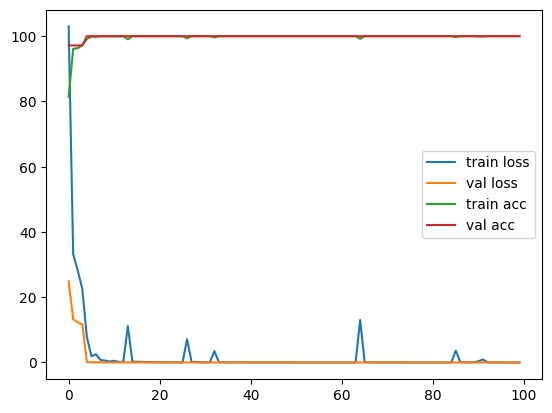

In [68]:
#plot loss and accuracy
plt.plot(train_loss, label="train loss")
plt.plot(val_loss, label="val loss")
plt.plot(train_acc, label="train acc")
plt.plot(val_acc, label="val acc")
plt.legend()
plt.show()